# ***Project Introduction***
In this project, we will be examining a dataset made up of observations on car accidents in the United States. This data is collected from MapQuest and Bing, and each row features a variety of attributes, such as different types of weather, location and address, and identifier data. Inspecting a few rows, we found that the main attributes of the data could be divided up into three main sections: weather, location, and time data. 

Our overarching goal in working with this data is to find trends in each of the sections as well as build and train models to make predictions. We are interested in this data because it is from recent years and car accidents are common in our everyday lives. Thus, it will be interesting to see what factors impact the severity of accident, for example, or where the density of accidents is highest in the United States. It will also be interesting to see if the COVID-19 pandemic had an impact on the number or frequency of accidents. 

Finally, we will be required to pare down our data, as we are given 4.2 million rows to begin with. As a result we choose to work with data from California and Washington state, which still leaves us with hundreds of thousands of rows. We will start with weather analysis to see how weather trends are represented in the data, and predict the severity of accidents based on weather features. We will then move into location data to plot the density of accidents on a map and train and evaluate a model based on location features as well. Finally, we take a look at trends in the accident data over time, comparing months of the year and time of day to see what effects the have on counts and severity of accidents.

## Introductory Data Loading and Setup

In [ ]:
!ls

gdrive	sample_data


In [ ]:

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
import matplotlib

import gc
import time
import warnings

import nltk
nltk.download('punkt')

from wordcloud import WordCloud
import matplotlib.pyplot as plt

from collections import Counter


from yellowbrick.cluster import KElbowVisualizer
from google.colab import drive
drive.mount('/content/gdrive')
import os
!pwd
#create folder called 545 in your drive, drop the "US_Accidents_Dec20.csv" file in there 
os.chdir("gdrive/MyDrive/545")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
data = pd.read_csv('US_Accidents_Dec20.csv', thousands=',')

In [ ]:
data.head(2)

ID    Source    TMC  ...  Civil_Twilight Nautical_Twilight Astronomical_Twilight
0  A-1  MapQuest  201.0  ...           Night             Night                 Night
1  A-2  MapQuest  201.0  ...           Night             Night                   Day

[2 rows x 49 columns]

In [ ]:
ca_ny = data[data["State"].isin(["CA","NY"])]
mapquest = data[data["Source"].isin(["MapQuest"])]
bing = data[data["Source"].isin(["Bing"])]
dataset_to_use = bing[bing["State"].isin(["CA","WA"])]

# only use bing 
dataset_to_use.head(2)

ID Source  ...  Nautical_Twilight  Astronomical_Twilight
2717489  A-2717612   Bing  ...                Day                    Day
2717490  A-2717613   Bing  ...                Day                    Day

[2 rows x 49 columns]

#***Beginning of Accident Weather Analysis (Brendan)***
In this section we will be performing many different kinds of analysis on many levels with the goal of investigating trends in weather and severity from the accident data. We begin with data cleaning as well as simple word aggregation and trend visualization. We then move into simple linear regression and compare models, and finally work with more complex models in PyTorch to try to build a model to predict the severity of an accident (integer categories of 1, 2, 3, or 4 from least to most severe) based on the weather attributes of that accident entry.

## Cleaning and preparing the data
Here we want to select a subset of the rows of our data, as we have way too many varied across sources and location, and we want a smaller set to work with.

We choose to work only with data sourced from Bing, as that is one of two sources and all Bing rows have the same features.

Next we choose only the data from California and Washington, as that still gives us enough data to work with and analyze overall trends (this does make it so our finds are only representative of those two states, but trends in weather and time for example should be similar across similar states).
We also need to turn time into datatime objects for convenience later.

In [ ]:
bing = data[data["Source"].isin(["Bing"])]
b = bing[bing["State"].isin(["CA","WA"])]

In [ ]:
weather_times = pd.to_datetime(b["Weather_Timestamp"])
start_times = pd.to_datetime(b["Start_Time"])
end_times = pd.to_datetime(b["End_Time"])

In [ ]:
# to avoid a warning:
import warnings

import pandas as pd
from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

weather_times

b["Weather_Timestamp"] = weather_times
b["Start_Time"] = start_times
b["End_Time"] = end_times


Just a quick note in the cleaning process, here we are getting rid of unnecessary columns that do not add anything to the analysis in this section.

In [ ]:
b = b.drop(labels=["Source", "TMC"], axis=1)
b.reset_index(inplace=True, drop=True)
#b.head(5)


##Word Analysis: see if low-level weather to severity analysis can be achieved based on most common words in accident description

Here we want to do a super basic word cloud/tokenizer technique like in HW2 of this class. Our goal is to use the description feature of each observation or row to extract the most common words based on severity of an accident. Then, we want to see if any weather-related words are common in severe or mild accidents.

First sort by severity (upper half vs. lower half of the 1-4 scale) and turn the descriptions into a list of words. Then, import the nltk tokenizer and use English stopwords.

In [ ]:
severe_df = b.loc[b['Severity'] > 2]
severe_df = severe_df.sort_values('Severity', ascending=False)
#severe_len = len(severe_df)

mild_df = b.loc[b['Severity'] < 3]
mild_df = mild_df.sort_values('Severity', ascending=False)

severe_content = severe_df['Description'].tolist()
mild_content = mild_df['Description'].tolist()
#severe_df
#mild_df

In [ ]:
mild_content[4]
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = set(stopwords.words('english')) 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#from hw2
def tokenize_content(content):

  words = nltk.word_tokenize(content)
  alpha = []
  for word in words:
    if word.isalpha():
      alpha.append(word)
  lowercase = []
  for word in alpha:
    lowercase.append(word.lower())
  final = []
  for word in lowercase:
    if word not in stopwords:
      final.append(word)
  return final

Using the tokenize function above, create a list of lowercase tokens for the alphanumeric words in the two description lists from above.

In [ ]:
severe = []
for body in severe_content:
  severe.append(tokenize_content(body))
mild = [] 
for body in mild_content:
  mild.append(tokenize_content(body))

severe_tokens = []
for inner in severe:
  for x in inner:
    severe_tokens.append(x)
mild_tokens = []
for inner in mild:
  for x in inner:
    mild_tokens.append(x)

Make a counter object that counts and then returns the most common words in the tokenized output from above, for both severe and mild accidents. Then, take the 20 most common distinct words from each and make a word cloud.

In [ ]:
mildest_counter = Counter(mild_tokens)
mild_most_common = mildest_counter.most_common(20)

severest_counter = Counter(severe_tokens)
sever_most_common = severest_counter.most_common(20)


distinct_sc = severest_counter.subtract(mildest_counter)
distinct_severest_common = severest_counter.most_common(20)
distinct_mc = mildest_counter.subtract(severest_counter)
distinct_mildest_common = mildest_counter.most_common(20)

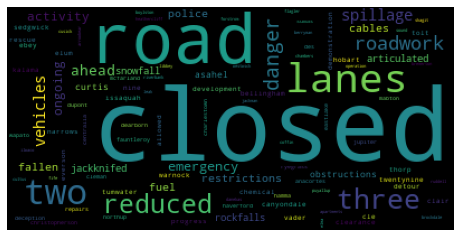

In [ ]:
severest_wordcloud = WordCloud().generate_from_frequencies(severest_counter)
plt.imshow(severest_wordcloud)
plt.axis("off")
plt.show()

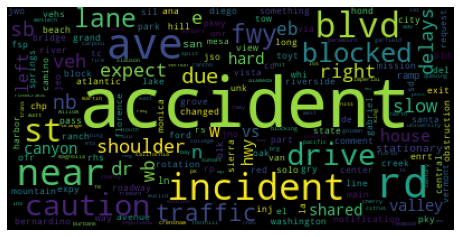

In [ ]:
mildest_wordcloud = WordCloud().generate_from_frequencies(mildest_counter)
plt.imshow(mildest_wordcloud)
plt.axis("off")
plt.show()

From above we see that some words are related to milder or more severe accidents, such as "closed", "ongoing", "restrictions", and "jacknifed" for severe and "incident", "accident", and various location words for mild. However, we do not see any weather words represented, so these are probably uncommon in accident descriptions if they are present at all. This was worth checking, though! The above words do tell us about location, the most common words based on severity, and the general nature of severe vs. mild accidents (as we see different hazards and more intense words for severe accidents and many benign, identifier-type words for mild ones).

##Data Visualization for Trends in Accident Attributes Based on Different Features

Now we want to check out different trends in our weather accident data using visualization. There are many different ways to visualize relationships between features and many different packages, a few of which we will display below. We mostly use aggregate measure to compare features to accident severity, and are required to regularize/scale data often to make the visuals more readable. We also check to see if the log transformation improves data visualization, and provide a simple correlation matrix to see how features are related.


Please note, the viewer may have to resize window or scale their view based on the computer used. Thank you for understanding.

Use the saved dataset from above, check out the first two rows to get an idea of what we're working with.

In [ ]:
w = b
w.head(2)

ID  Severity  ... Nautical_Twilight Astronomical_Twilight
0  A-2717612         3  ...               Day                   Day
1  A-2717613         2  ...               Day                   Day

[2 rows x 47 columns]

The features we will be comparing to severity are Weather Condition, Visibility(mi), and Temperature(F). Here we take the mean severity for each level of those attributes, and create a new count column/value for each attribute as well.

In [ ]:
# average severity vs weather condition
w_avg = w.groupby(['Weather_Condition']).mean().reset_index()[['Weather_Condition', 'Severity']]
w_avg.rename(columns={'Severity' : "Average_Severity"}, inplace=True)
w_avg['Count'] = w.groupby(["Weather_Condition"]).count().reset_index()['Severity']
w_avg = w_avg.sort_values(by='Average_Severity', ascending=False)

#above but with visibility
w_vis = w.groupby(['Visibility(mi)']).mean().reset_index()[['Visibility(mi)', 'Severity']]
w_vis.rename(columns={'Severity' : "Average_Severity"}, inplace=True)
w_vis['Count'] = w.groupby(["Visibility(mi)"]).count().reset_index()['Severity']
w_vis = w_vis.sort_values(by='Average_Severity', ascending=False)

# same as above with temps, want increments of 10?
w_temp = w.groupby(['Temperature(F)']).mean().reset_index()[['Temperature(F)', 'Severity']]
w_temp.rename(columns={'Severity' : "Average_Severity"}, inplace=True)
w_temp['Count'] = w.groupby(["Temperature(F)"]).count().reset_index()['Severity']
w_temp = w_temp.sort_values(by='Average_Severity', ascending=False)


# drop the ones with 0 visibility, those are errors
w_vis.drop(w_vis.loc[w_vis['Visibility(mi)']==0.00].index, inplace=True)

### Plot severity vs. weather types, relevant for neural networks later!

Here we create the plots for severity vs. weather conditions, using the Seaborn package. Notice that the counts for each weather condition vary wildly so the data available is not the most useful, but it still provides a valid trend for visualization and we observe the bigger picture when sorting by most severe and least severe.

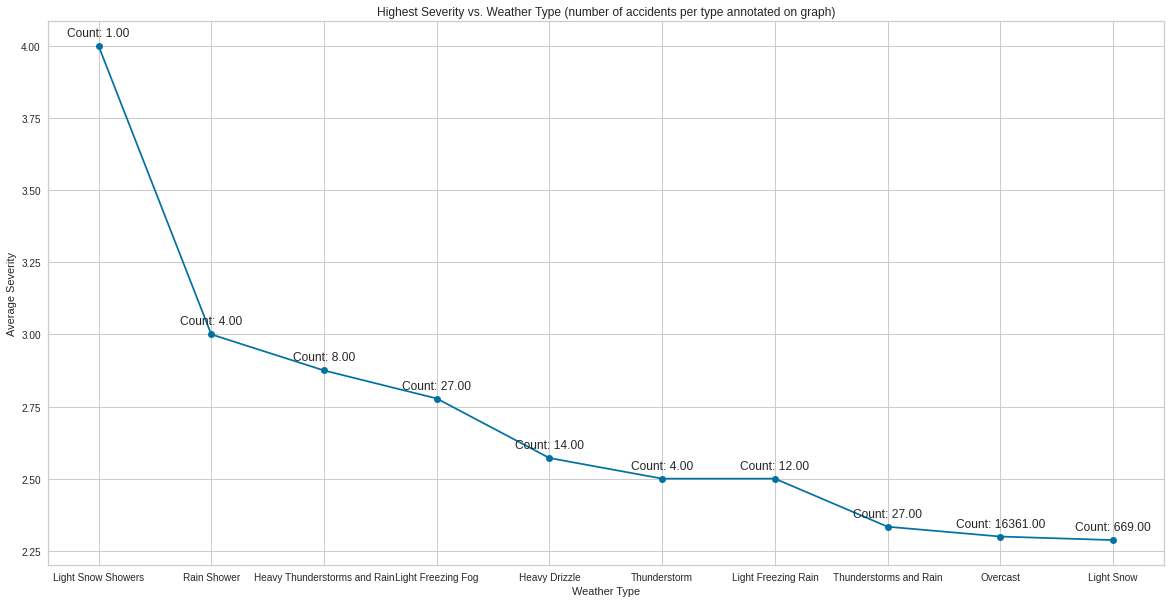

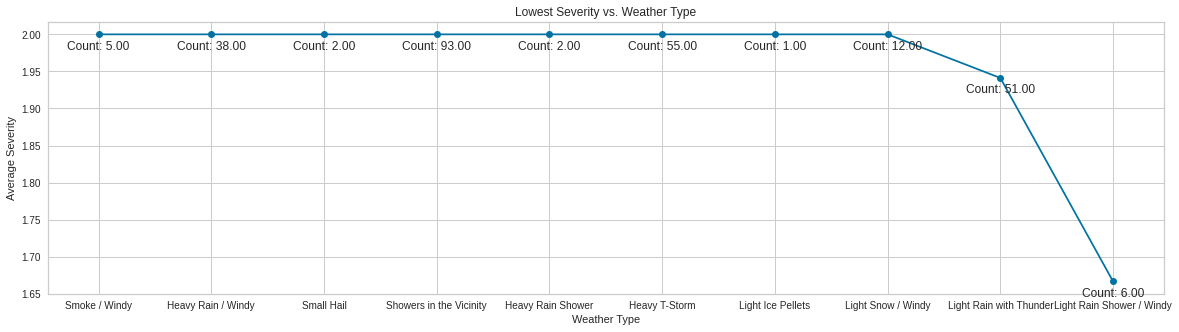

In [ ]:

# 10 MOST SEVERE weather condition first
x1 = w_avg["Weather_Condition"].head(10)
y1 = w_avg["Average_Severity"].head(10)
plt.figure(figsize=(20,10))
plt.plot(x1, y1, 'bo-', label = "Severity")
# count annotations source here: https://queirozf.com/entries/add-labels-and-text-to-matplotlib-plots-annotation-examples
i = 0
for x,y in zip(x1,y1):
  label = "Count: " + "{:.2f}".format(w_avg["Count"].iloc[i])
  plt.annotate(label, (x,y), xytext=(0,10), textcoords="offset points", ha="center")
  i += 1

plt.xticks(x1)
plt.xlabel('Weather Type')
plt.ylabel('Average Severity')
plt.title('Highest Severity vs. Weather Type (number of accidents per type annotated on graph)')
plt.show()

# 10 LEAST SEVERE weather condition next
x2 = w_avg["Weather_Condition"].tail(10)
y2 = w_avg["Average_Severity"].tail(10)
plt.figure(figsize=(20,5))
plt.plot(x2, y2, 'bo-', label = "Severity")
i = len(w_avg) - 10
for x,y in zip(x2,y2):
  label = "Count: " + "{:.2f}".format(w_avg["Count"].iloc[i])
  plt.annotate(label, (x,y), xytext=(0, -15), textcoords="offset points", ha="center")
  i += 1
plt.xticks(x2)
plt.xlabel('Weather Type')
plt.ylabel('Average Severity')
plt.title('Lowest Severity vs. Weather Type')
plt.show()



So above we see that light snow, rain, thunderstorms, freezing fog, and heay drizzle are commonly the weather conditions that result in the most severe accidents. We also see, interestingly, that light ice, light snow, light rain/thunder, and light rain/wind cause on average the least severe accidents. This may seem a little unexpected but it would make sense in the interpretation that any light weather is hardly present at all.

Also note that the counts do vary so the above conclusions may abe influenced by the number of accidents in specific conditions. The ones with higher counts, however, like overcast, light snow, and light rain, should be representative of their overall average severities. Lastly in the most mild accidents, we see that many conditions have an average severity of 2.00, so it's worth considering that our data may feature a sort of "default" severity or a "most common" severity that is input as a data entry when it is not very bad or very mild - this would make it so many weather conditions have the same average severity rating.

### Plot different aggregate (used averages) measure vs. severity

Now what we want to do is use line graphs to discern overall trends in Severity vs. Temperature and Visibility, as those are on a pretty continuous scale in a pretty well defined range. Using regularization and some scaling, we are able to make initially spiky and unappealing graphs into readable figures that plot our trends reasonable well.

Here we find average severity based on visibility distances, then focus on distances from 0 to 35 miles as those appear to be more interesting and should be easier to see. Next we use a spline to smooth the lines between spikes in the data and analyze our results.

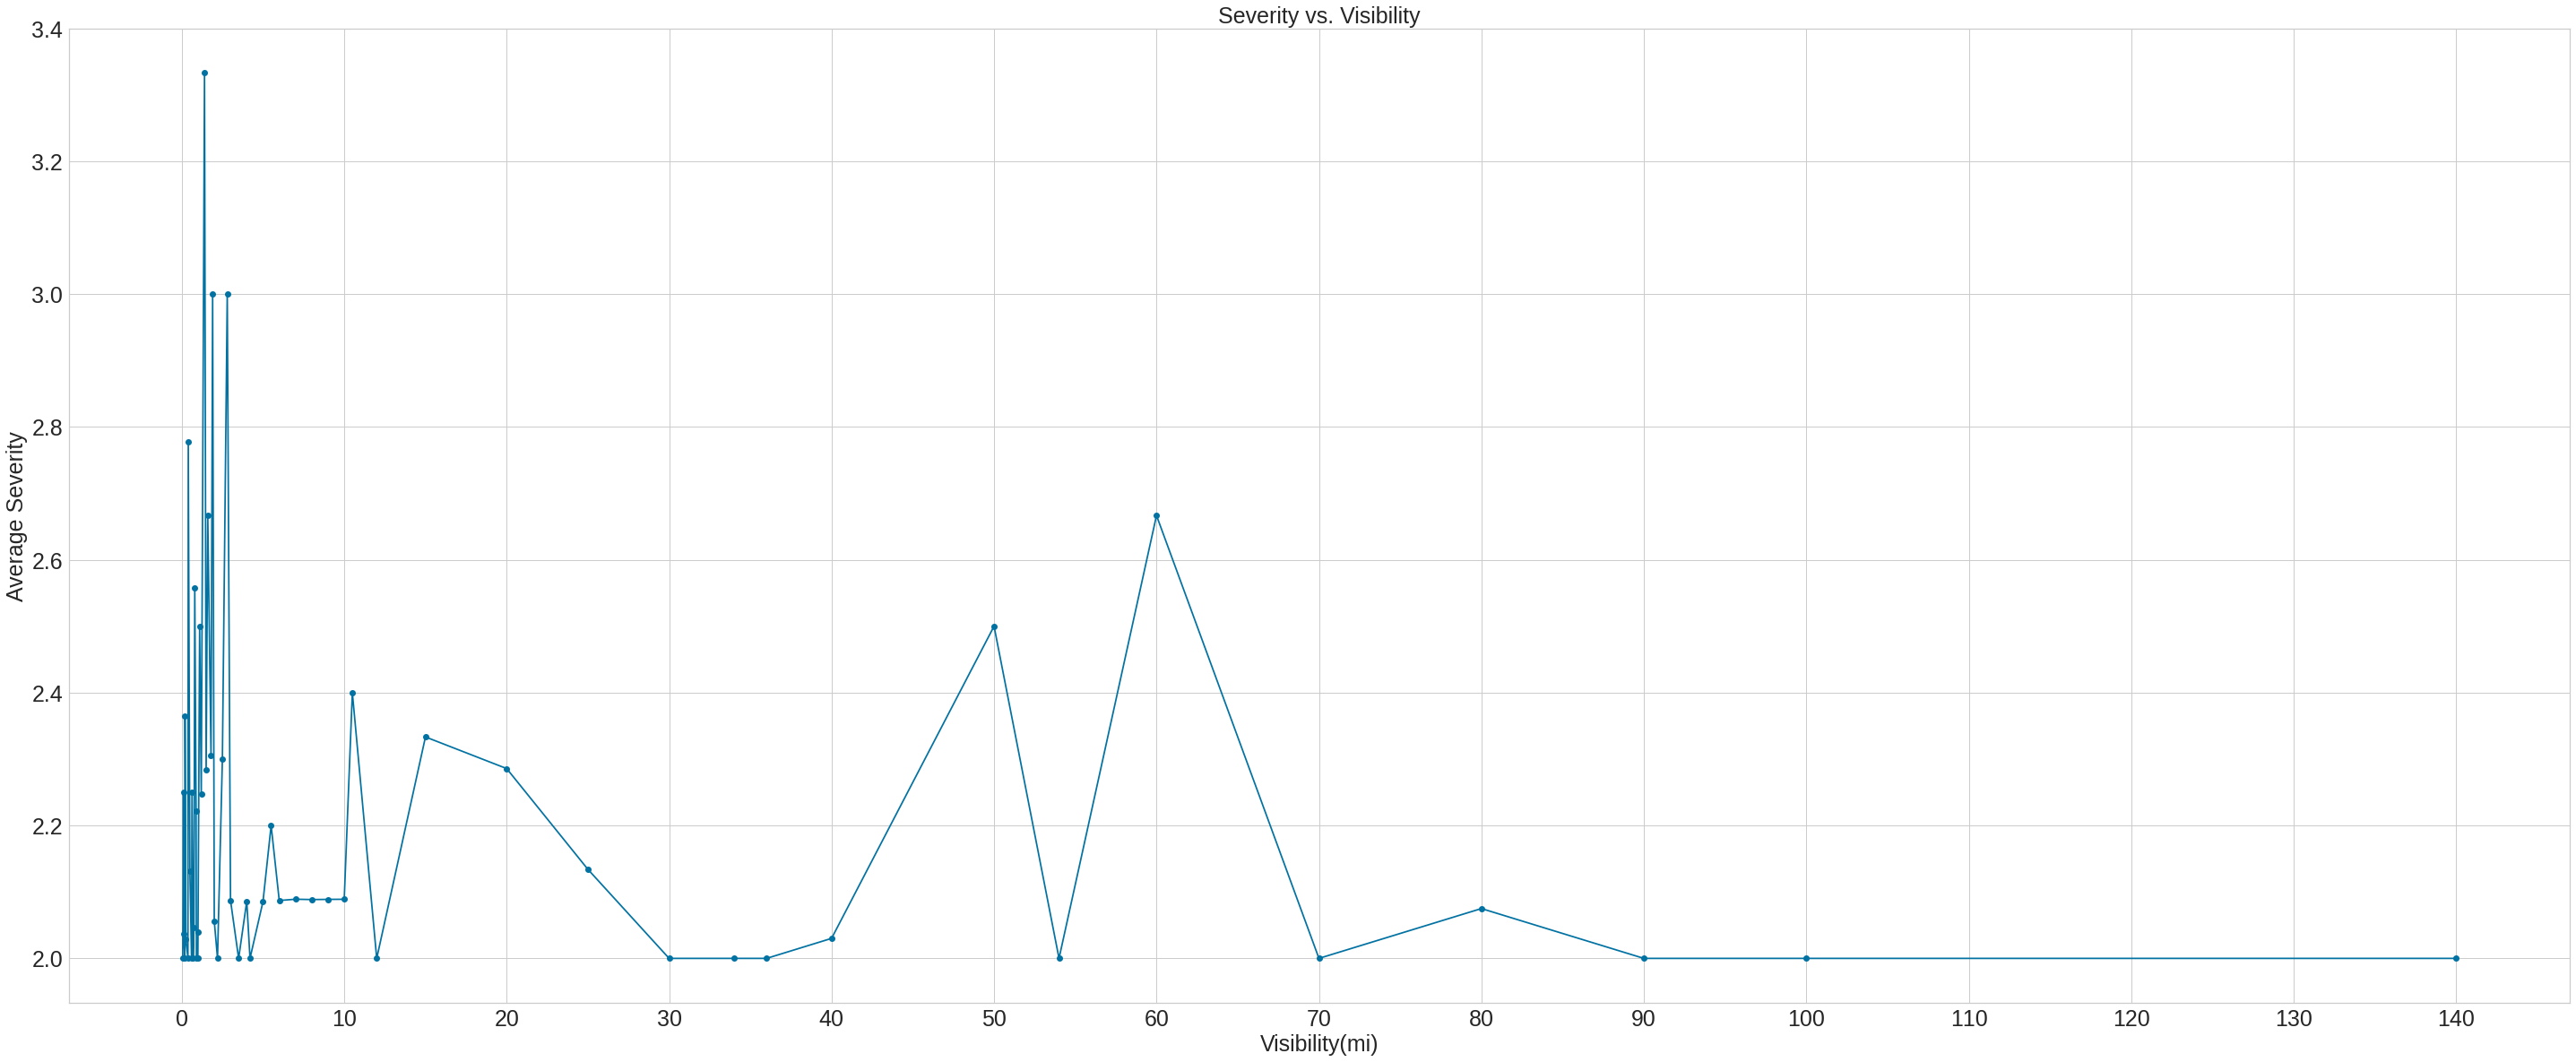

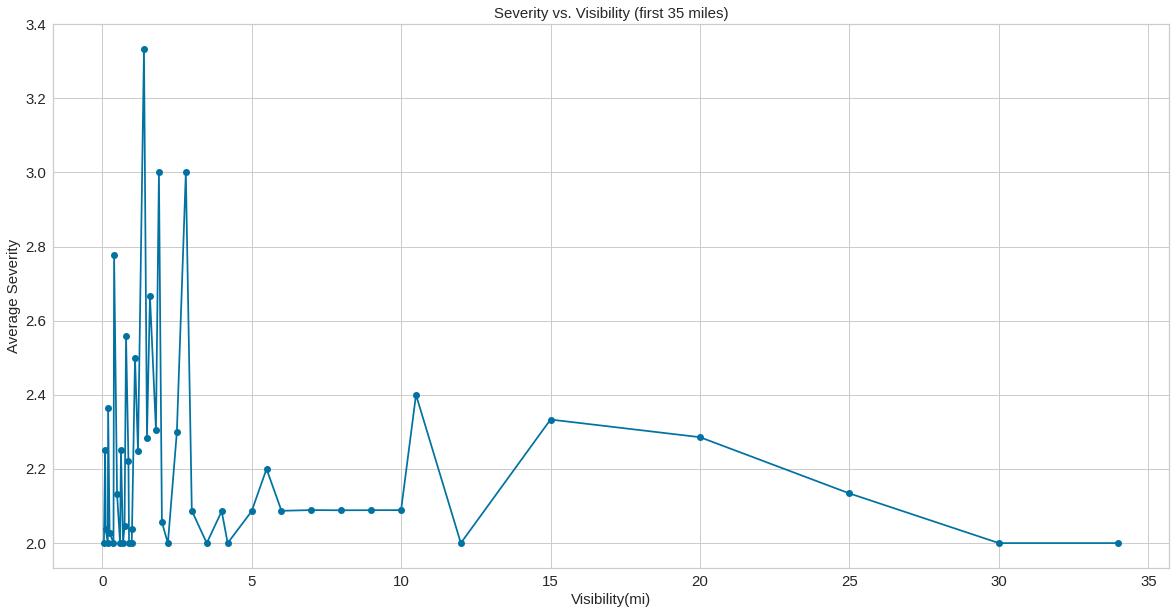

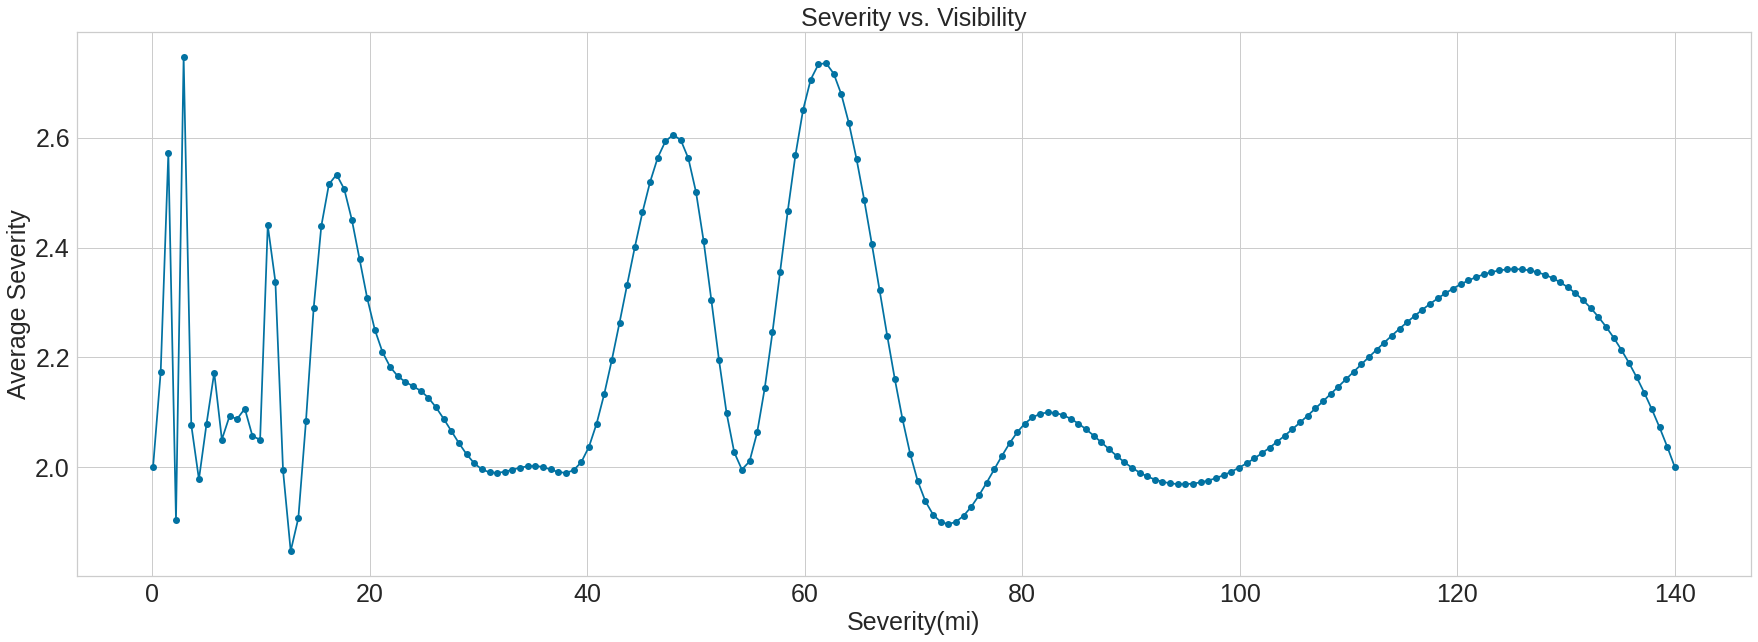

In [ ]:
# 10 MOST SEVERE visibility first
w_vis = w_vis.sort_index()
x1 = w_vis["Visibility(mi)"]
y1 = w_vis["Average_Severity"]
plt.figure(figsize=(50,20))
plt.plot(x1, y1, 'bo-', label = "Severity")

plt.xticks(x1)
plt.xlabel('Visibility(mi)', fontsize=25)
plt.ylabel('Average Severity', fontsize=25)
plt.title('Severity vs. Visibility', fontsize=25)
plt.xticks(np.arange(0, 150, 10.0), fontsize=25)
plt.yticks(fontsize=25)
plt.show()

# looks a bit jumbled, focus on visibility distances from 0 to 35
w_vis2 = w_vis.loc[w_vis['Visibility(mi)'] <= 35.0]
x2 = w_vis2["Visibility(mi)"]
y2 = w_vis2["Average_Severity"]
plt.figure(figsize=(20, 10))
plt.plot(x2, y2, 'bo-', label = "Severity")

plt.xlabel('Visibility(mi)', fontsize=15)
plt.ylabel('Average Severity', fontsize=15)
plt.title('Severity vs. Visibility (first 35 miles)', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

# still looks pretty bad, try to normalize: https://www.statology.org/matplotlib-smooth-curve/
from scipy.interpolate import make_interp_spline, BSpline
w_vis = w_vis.sort_index()
x3 = w_vis["Visibility(mi)"]
y3 = w_vis["Average_Severity"]
#define x as 200 equally spaced values between the min and max of original x 
xnew = np.linspace(x3.min(), x3.max(), 200) 

#define spline
spl = make_interp_spline(x3, y3, k=3)
y_smooth = spl(xnew)

plt.figure(figsize=(30,10))
plt.plot(xnew, y_smooth, 'bo-', label = "Severity")

plt.xlabel('Severity(mi)', fontsize=25)
plt.ylabel('Average Severity', fontsize=25)
plt.title('Severity vs. Visibility', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.show()

So here we see that in the beginning the data was choppy, hard to view, and needed some kind of modification to see real trends. We did this as described above and arrived at the decent result in the last figure. This shows us, as ecpected that there are large spikes in severity of accidents at low visibility, decently high severity up to 20 miles, and then it flattens a little. What is unexpected is the jumps in severity around 45-65 miles in visibility, but these may be cases where most accidents happen, and so the average is brought higher by sheer number of severe accidents as opposed to the very few (and mostly severe) accidents that happen at low visibility. Lastly the hump around 120 miles makes sense because these accidents probably happen on interstates or with high visibility where vehicles are moving faster and thus cause more severe accidents when accidents occur (also could be because more accidents occur at these visibility conditions, as discussed above).

In this section we graph temperative vs average visibility in a similar way as above. Again we use a spline to smooth the extremely spiky data in our first graph and get a relatively nice graph in the end with discernable trends. We see that average severity rises when temperatures are very cold or very hot, as expected, as freezing alters road conditions and extreme heat can cause driver impairment or mechanical issues as well. We also see that the average severity for other more common temperature is just above 2, which seems to be expected as mild or non-extreme temperatures should not increase the severity of an accident.

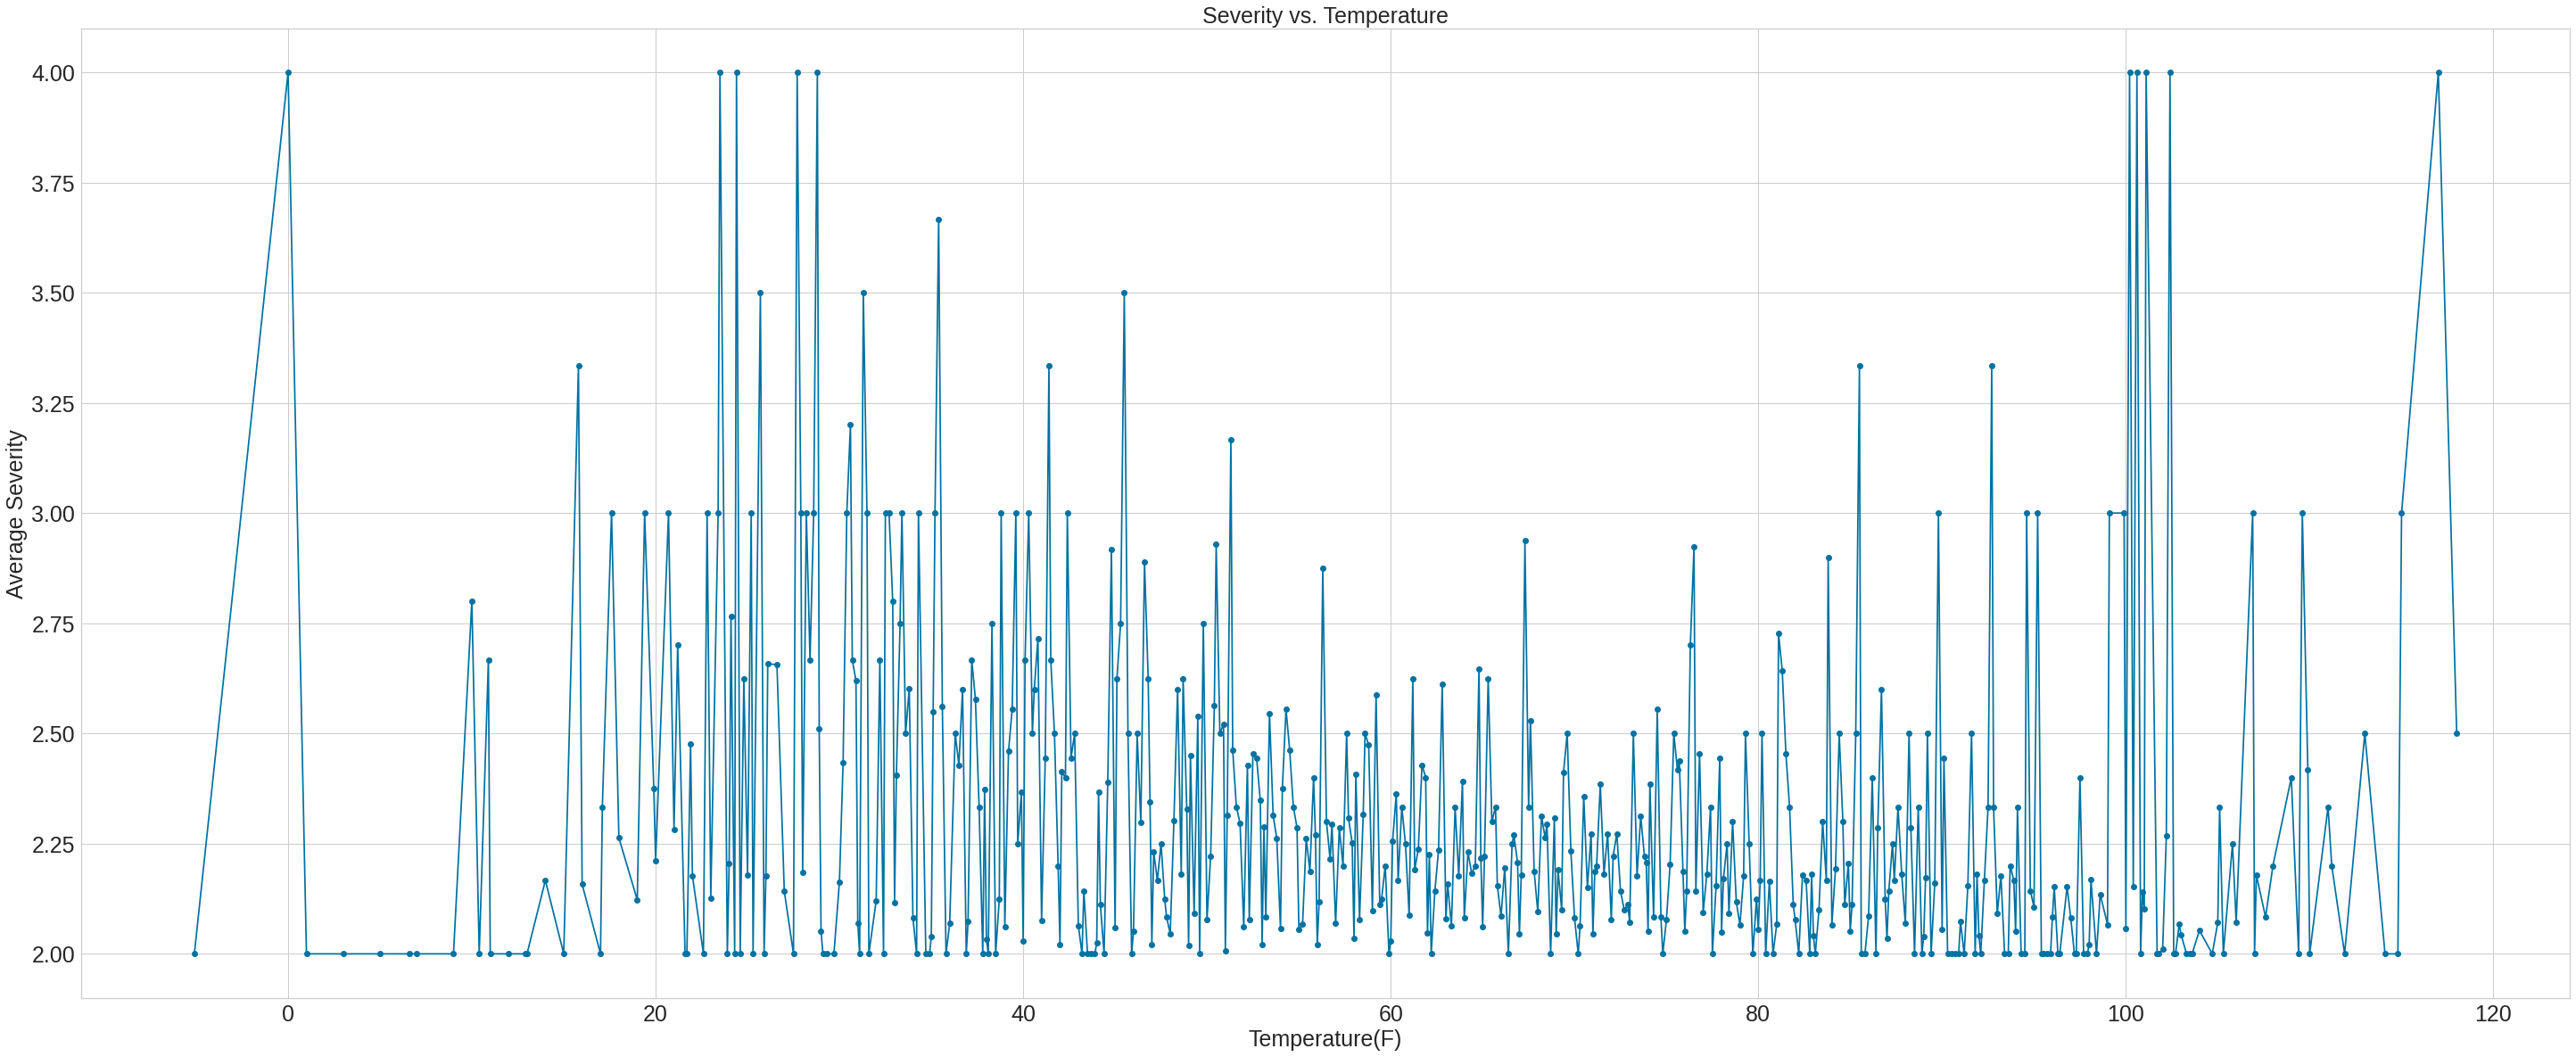

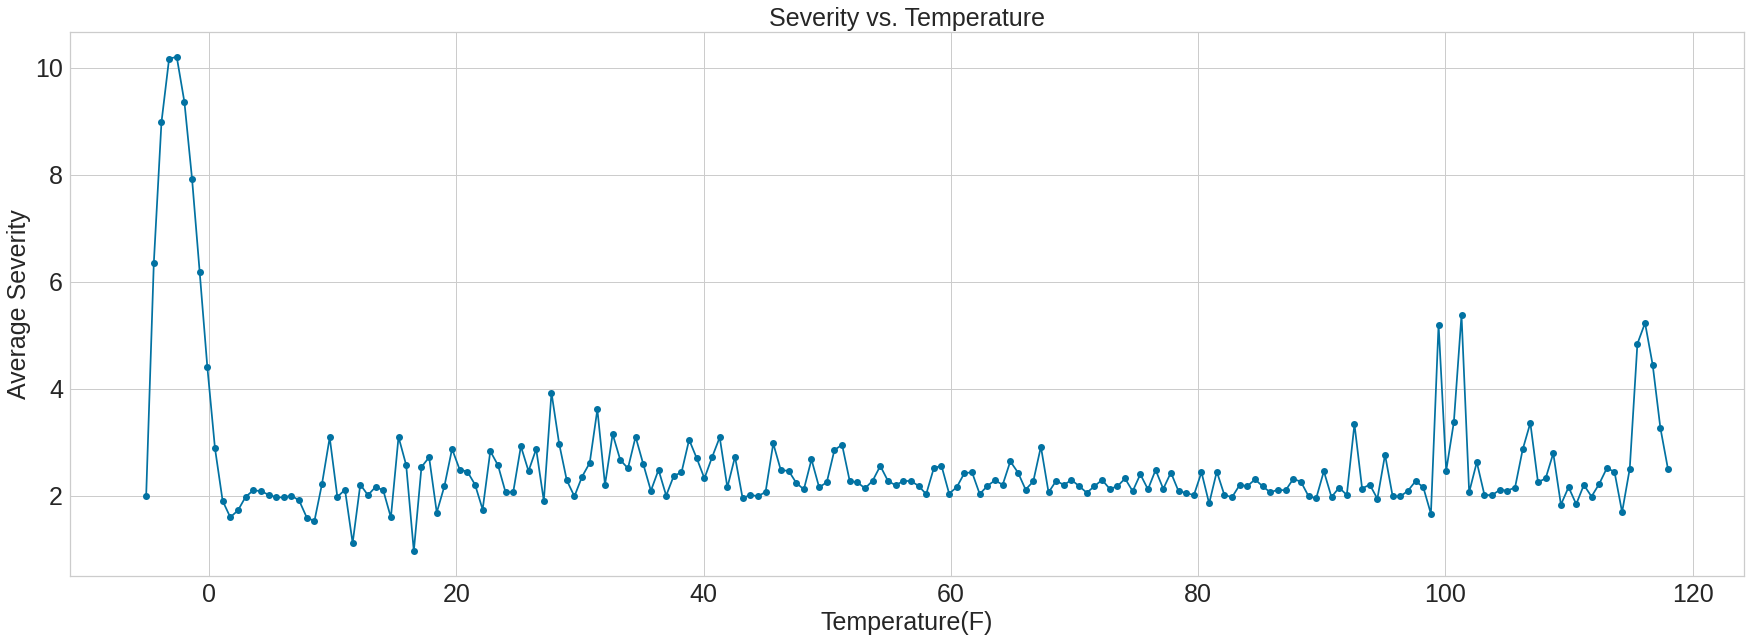

In [ ]:
# note these don't tell us much, hence the need for combining features, not just a single one and severity
# 10 MOST SEVERE visibility first
w_temp = w_temp.sort_index()
x1 = w_temp["Temperature(F)"]
y1 = w_temp["Average_Severity"]
plt.figure(figsize=(50,20))

plt.plot(x1, y1, 'bo-', label = "Severity")
# count annotations here: https://queirozf.com/entries/add-labels-and-text-to-matplotlib-plots-annotation-examples


plt.xlabel('Temperature(F)', fontsize=25)
plt.ylabel('Average Severity', fontsize=25)
plt.title('Severity vs. Temperature', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

plt.show()

# looks pretty bad, try to normalize: https://www.statology.org/matplotlib-smooth-curve/
from scipy.interpolate import make_interp_spline, BSpline
w_temp = w_temp.sort_index()
x2 = w_temp["Temperature(F)"]
y2 = w_temp["Average_Severity"]
#define x as 200 equally spaced values between the min and max of original x 
xnew = np.linspace(x2.min(), x2.max(), 200) 

#define spline
spl = make_interp_spline(x2, y2, k=3)
y_smooth = spl(xnew)

plt.figure(figsize=(30,10))
plt.plot(xnew, y_smooth, 'bo-', label = "Severity")

plt.xlabel('Temperature(F)', fontsize=25)
plt.ylabel('Average Severity', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.title('Severity vs. Temperature', fontsize=25)
plt.show()


Please note, in the above regularized graph the spline changed the scale of the datapoints. This is because of the way spline interpolates and the degree of the line we chose. This scale is fine, however, as we are only looking for general trends and this still shows us the spikes in severity at low and high temperatures as well as the relative similarity of average similarity between those extremes.

### Rescale and clean data for easier visualization in later plots, examine general trends

In this section, we use the same dataset as in the beginning of this section and make a few adjustments. We take only weather related columns, clean up null and non-measured (usually represented as 0.00) values, and make sure we are still left with a decent amount of rows for analysis (~300k is more than enough).


In [ ]:
w = b


In [ ]:

# only use weather related columns:
w = w[["Severity", "Distance(mi)", "Weather_Timestamp", "Temperature(F)", "Wind_Chill(F)", "Humidity(%)", "Pressure(in)", "Visibility(mi)", "Wind_Direction", "Wind_Speed(mph)", "Precipitation(in)", "Weather_Condition"]]
w.head(3)

# cleanup of null values
w.drop(w.loc[w['Visibility(mi)']==0.00].index, inplace=True)
w = w[w["Precipitation(in)"].notna()]
w["Wind_Chill(F)"].fillna(value=w["Temperature(F)"], inplace=True)
w = w[w["Wind_Speed(mph)"].notna()]
w = w.dropna()
len(w)

308128

Here we examine the max, min, standard deviation, and mean of a variety of features in our weather data, just to get an idea of what to expect in later visualization and what is common or uncommon in our chosen data. 

We see mostly what we expect, like minimum wind chill being -10.0F, max distance being ~61 miles, and average temperature being ~61F.


We also rescale certain features using log to reduce variance, and take the absolute value if needed for negative value (only needed in a single case, temperature).

In [ ]:
# do some data analysis, corr matrix later
w.head(5)
# Basic EDA using statistics of numerical features
maxs = [w["Distance(mi)"].max(), w["Temperature(F)"].max(), w["Wind_Chill(F)"].max(), w["Humidity(%)"].max(), w["Pressure(in)"].max(), w["Visibility(mi)"].max(), w["Wind_Speed(mph)"].max(), w["Precipitation(in)"].max()]
mins = [w["Distance(mi)"].min(), w["Temperature(F)"].min(), w["Wind_Chill(F)"].min(), w["Humidity(%)"].min(), w["Pressure(in)"].min(), w["Visibility(mi)"].min(), w["Wind_Speed(mph)"].min(), w["Precipitation(in)"].min()]
stds = [w["Distance(mi)"].std(), w["Temperature(F)"].std(), w["Wind_Chill(F)"].std(), w["Humidity(%)"].std(), w["Pressure(in)"].std(), w["Visibility(mi)"].std(), w["Wind_Speed(mph)"].std(), w["Precipitation(in)"].std()]
means = [w["Distance(mi)"].mean(), w["Temperature(F)"].mean(), w["Wind_Chill(F)"].mean(), w["Humidity(%)"].mean(), w["Pressure(in)"].mean(), w["Visibility(mi)"].mean(), w["Wind_Speed(mph)"].mean(), w["Precipitation(in)"].mean()]
print(maxs, mins, stds, means)


[61.085, 113.0, 113.0, 100.0, 58.04, 100.0, 142.0, 2.73] [0.0, 1.0, -10.0, 1.0, 20.04, 0.06, 0.0, 0.0] [0.8123598582330028, 13.367572998957304, 13.844033597022086, 24.479289616458423, 0.8235817915019, 2.6832587341623153, 5.139151496811857, 0.027034155634511982] [0.27330105670370397, 61.50302374337976, 61.20702045903002, 59.12995897808703, 29.54020244833175, 8.975440401391621, 5.611748688856637, 0.0044861875584165595]


In [ ]:
# rescale numerical features
w['dist_log'] = np.log(w["Distance(mi)"] + 1)

def log_abs(col):
  result = []
  for x in col:
    if (x < 0):
      result.append(-1 * np.log(abs(x) + 1))
    else:
      result.append(np.log(x + 1))
  return result

w['temp_log'] = np.log(w["Temperature(F)"] + 1)
w['wind_chill_log'] = log_abs(w["Wind_Chill(F)"])

w['humidity_log'] = np.log(w["Humidity(%)"] + 1)
w['press_log'] = np.log(w["Pressure(in)"] + 1)
w['vis_log'] = np.log(w["Visibility(mi)"] + 1)
w['wind_spd_log'] = np.log(w["Wind_Speed(mph)"] + 1)
w['precip_log'] = np.log(w["Precipitation(in)"] + 1)
w_clean = w

Here we visualize all of the above log transformed data, plotting different log values vs. each other. Marginal distributions are also plotted along the diagonal for all variables. Some appear centered a specific value but most are heavily skewed, as to be expected for attributes like accident distance (most are short), and precipitation (often very little rainfall). These are decent for viewing basic distributions of values for many of the attributes, but do not provide much more insight after that. 

Note: we take a sample of 10000 accidents in order to create a sns plot in an efficient manner, so there is a chance they are not representative ove the entire ~300000 observations. However the sample is random so there is a decent chance our plot shows the general trends in our data.

In [ ]:
w.head(2)

Severity  Distance(mi)  ... wind_spd_log  precip_log
219         2         0.223  ...     2.433613         0.0
221         2         0.062  ...     2.525729         0.0

[2 rows x 20 columns]

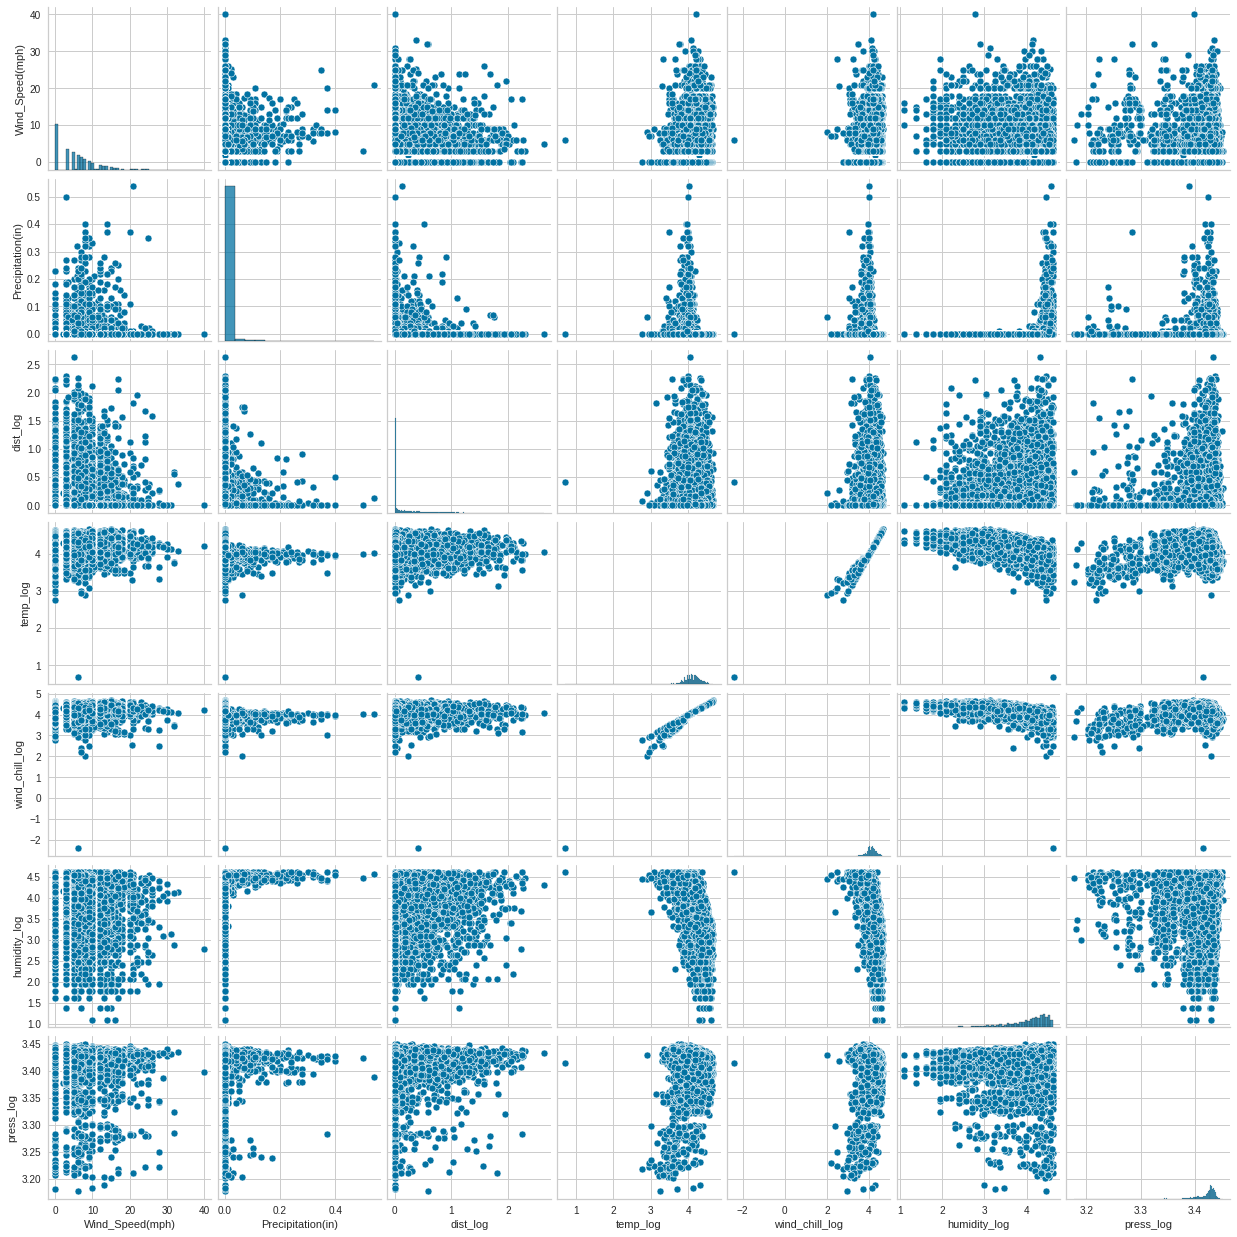

In [ ]:
import seaborn as sns

# first select the range of columns we want, the log ones: 
w_logs = w.iloc[:, 9:17]
sns.pairplot(w_logs.sample(10000))

So from the above pairplot we see how different variables are related in a graphical format. This shows us, for example, that high precipitation features high humidity, and temperature is higher for lower humidity and vice versa. We also see from the marginal distributions, for example, that most accidents featured little precipitation, wind speed is approximately normal, and so is temperature and wind chill. This is a cool visual and allows us to understand a little more about how our variables are related and distributed.

Next we create a correlation matrix just to get a broad idea of how features of our accident data are related and to see if these relationships are what we expect or less so.

First we exclude the weather condition and wind direction features aso those are one-hot and not really what we are looking for. We want to examine relationships between the numerical attributes of our data, and we also exclude log columns as they would mirror the columns they were created from.

In [ ]:
w_select = w[["Severity",	"Distance(mi)", "Temperature(F)", "Wind_Chill(F)", "Humidity(%)",	"Pressure(in)",	"Visibility(mi)",	"Wind_Speed(mph)", "Precipitation(in)"]]

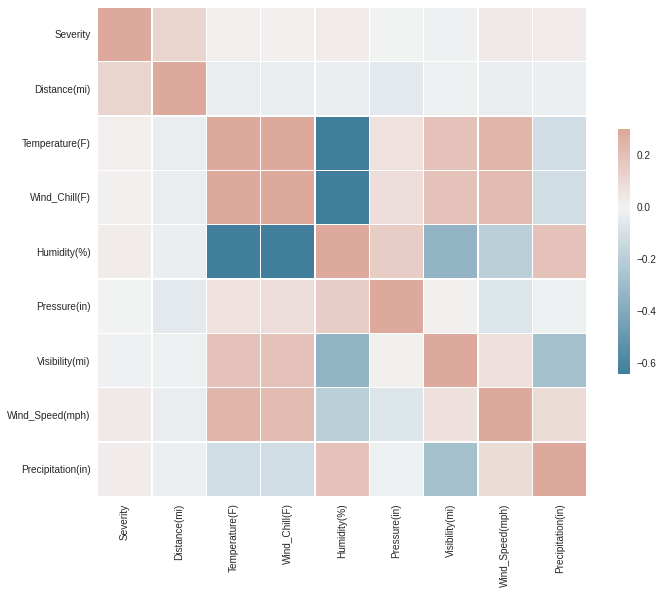

In [ ]:
# source for correlation matrix: https://seaborn.pydata.org/examples/many_pairwise_correlations.html
corr = w_select.corr()
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


So in the above correlation matrix we mostly see what we would expect. It makes sense that temperature and visibility are related (hotter means clearer usually so can see further), as are wind chill and wind speed. It also makes sense that severity and distance of an accident are loosely related as the further an accident travels the more severe it should be and vice cersa. It is a little surprising that temperature and humidity are not correlated and the same with humidity and visibility, but those are not necessarily related for some weather phenomenon so this is definitely possible. 

For the last part of this section, we create average log temperature, visibility, and wind speed variables for each different weather condition type that is possible in our data. We do this to see how these three attributes vary by weather condition to again gain more insight into which features are more or less related than others. What results is we see that conditions like cloudy, overcase, and some thunderstorms have higher temperature, while snow conditions have lower temperature as expected. In terms of visibiliy we see that conditions like heavy snow, fog, and rain have the worst (lowest) visibility, and conditions like windy or lighter conditions have higher visibility, as expected just from general knowledge and what is known about visibility during clouds and similar phenomenon. Finally, we see that wind speed is commonly lowest in conditions like fog and haze (which makes sense as those are present when there is no wind to change the atmosphere), and it is highest in conditions like blowing dust, thunder storms, and any condition that mentions "windy" in the name. 

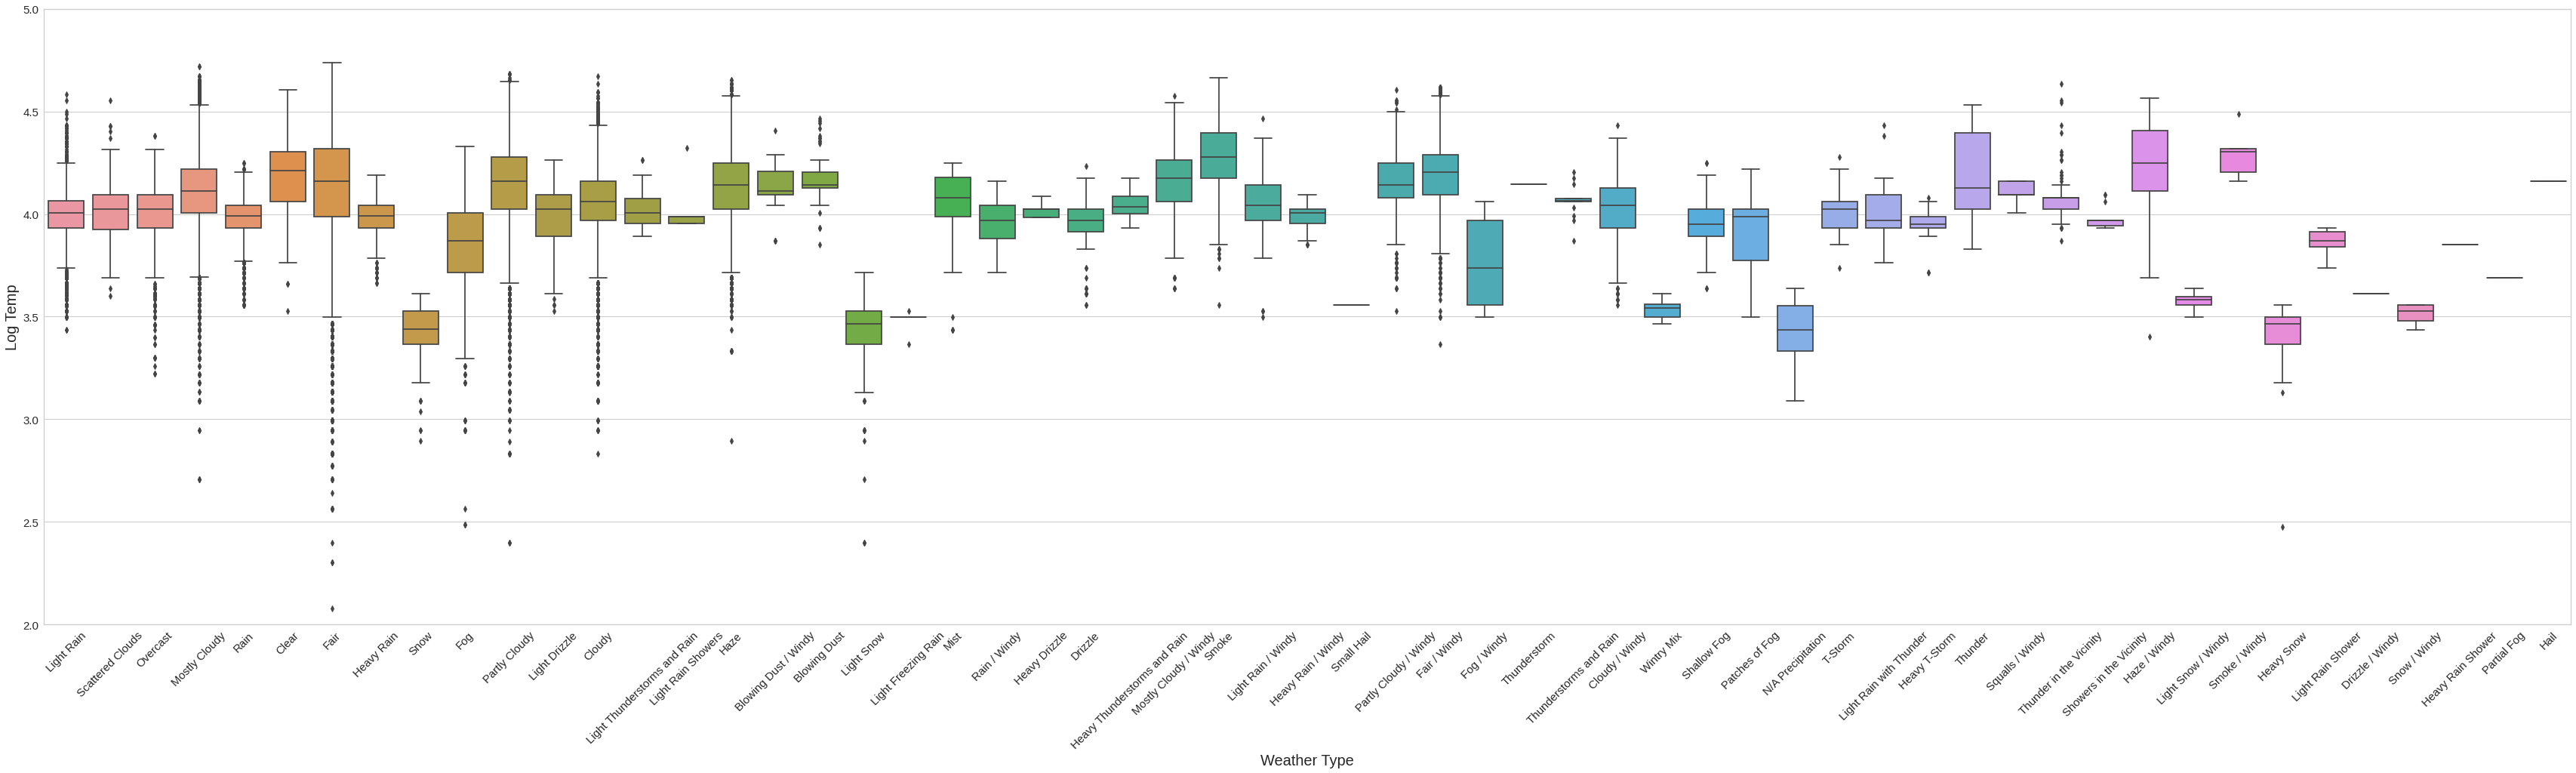

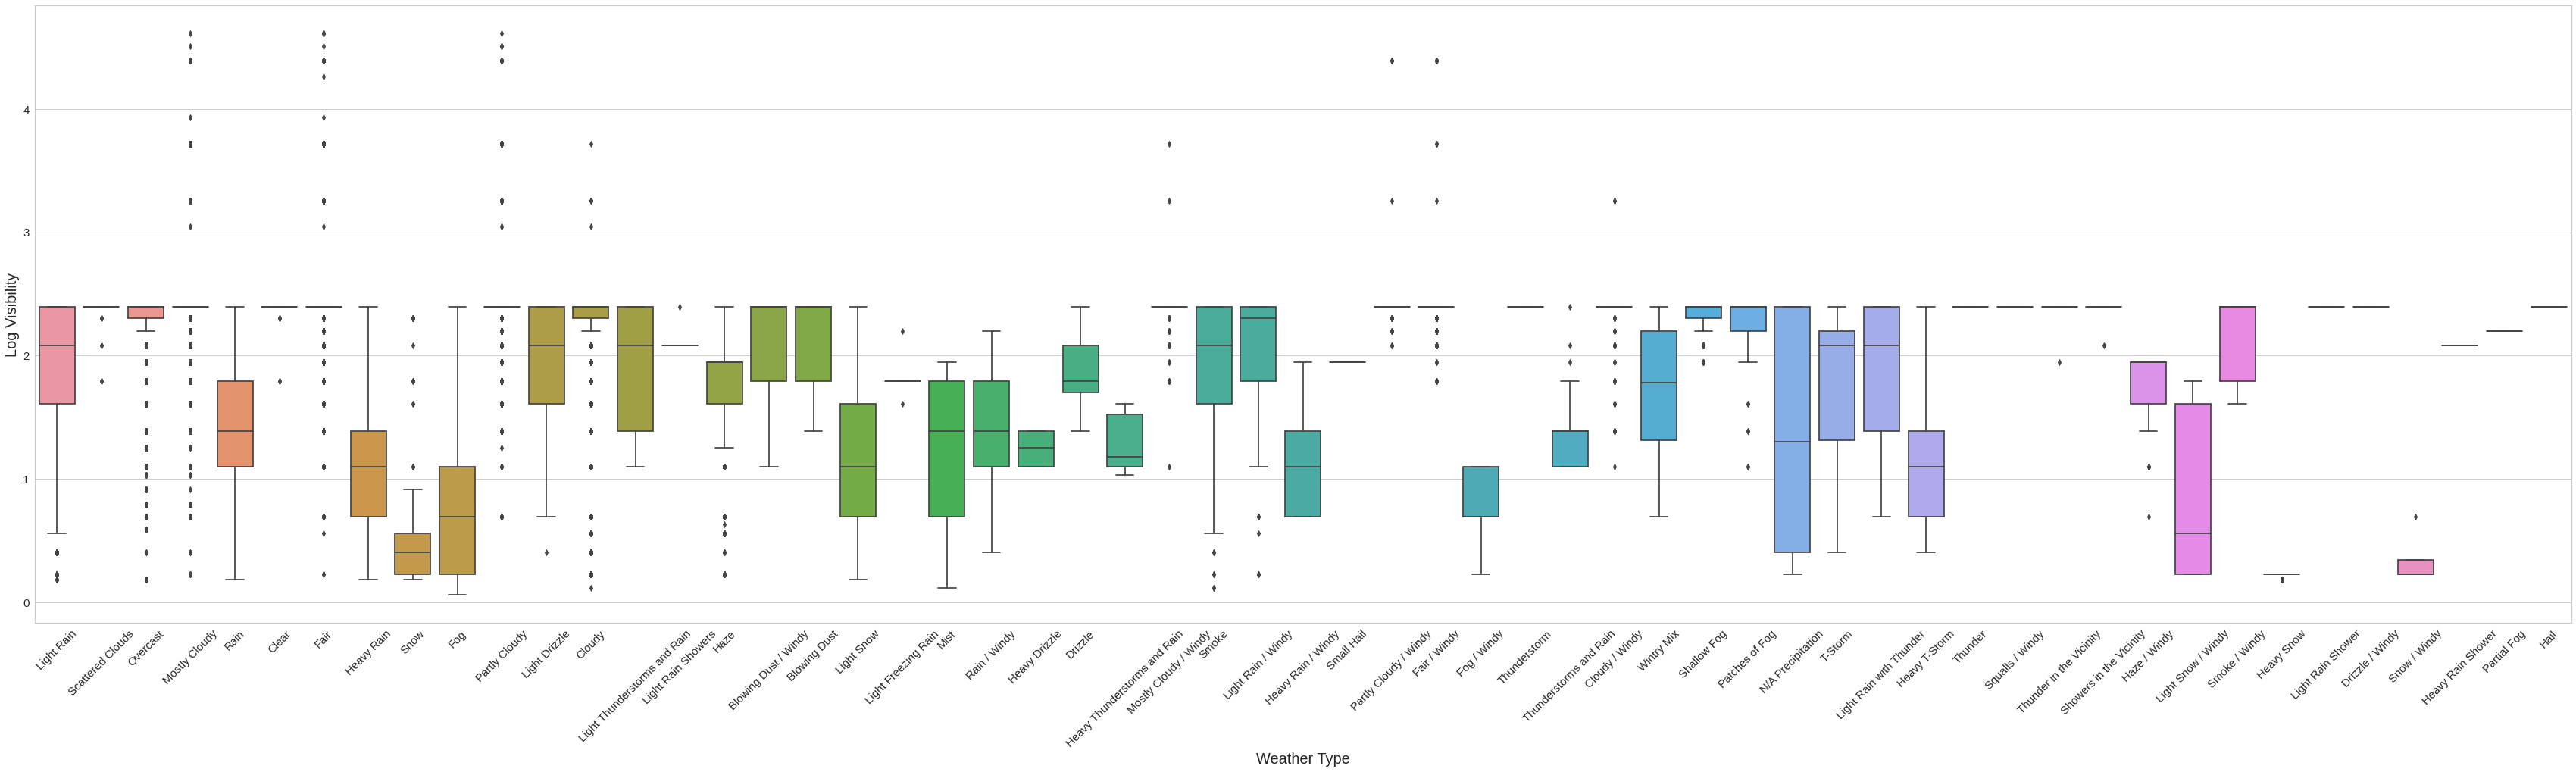

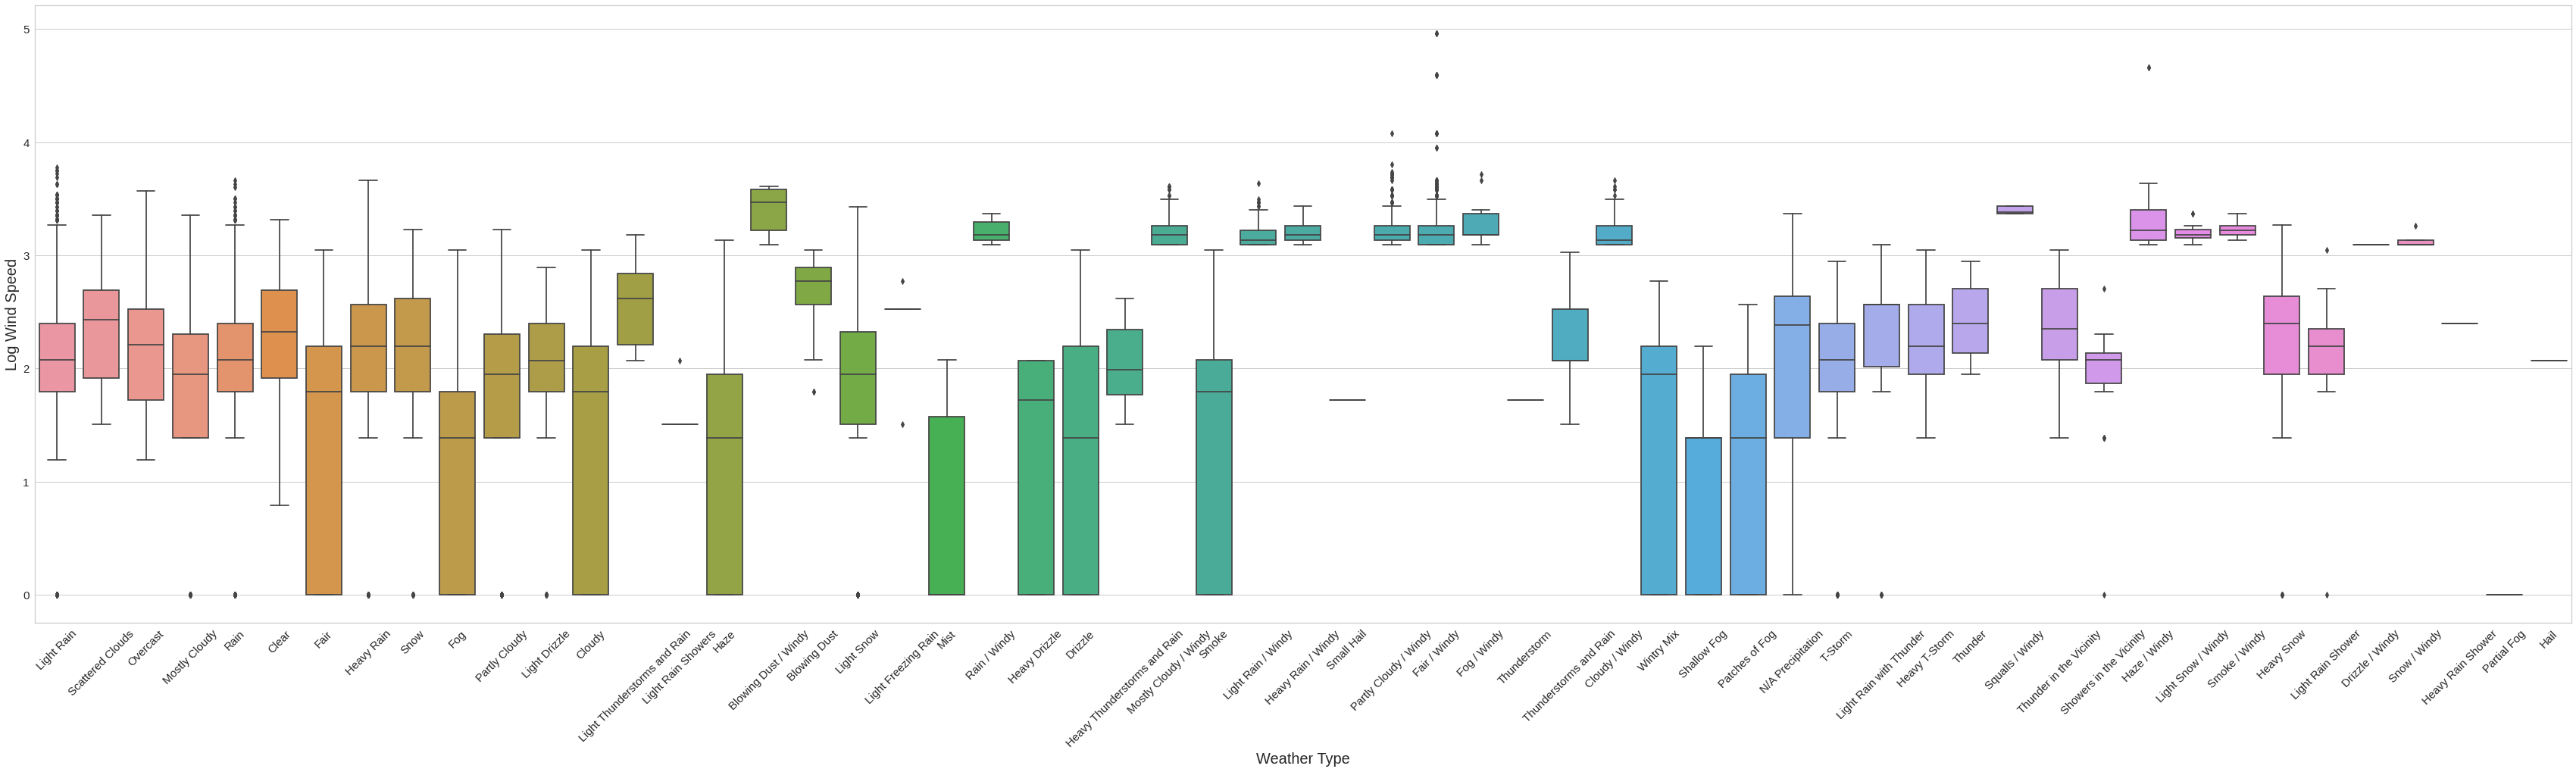

In [ ]:
# temp, wind speed, visibility graphs for type of weather

plt.figure(figsize=(60, 15))
graph = sns.boxplot(x = w['Weather_Condition'], y = w['temp_log'])

graph.set_xticklabels(graph.get_xmajorticklabels(), fontsize = 12)
graph.set_xticklabels(graph.get_xticklabels(), rotation=45 )
graph.set_xlabel("Weather Type", fontsize=20)
graph.set_ylabel("Log Temp", fontsize=20)
graph.tick_params(labelsize=15)
graph.set(ylim=(2.0, 5.0))
plt.show()

plt.figure(figsize=(60, 15))
graph = sns.boxplot(x = w['Weather_Condition'], y = w['vis_log'])

graph.set_xticklabels(graph.get_xmajorticklabels(), fontsize = 12)
graph.set_xticklabels(graph.get_xticklabels(), rotation=45 )
graph.set_xlabel("Weather Type", fontsize=20)
graph.set_ylabel("Log Visibility", fontsize=20)
graph.tick_params(labelsize=15)
plt.show()

plt.figure(figsize=(60, 15))
graph = sns.boxplot(x = w['Weather_Condition'], y = w['wind_spd_log'])

graph.set_xticklabels(graph.get_xmajorticklabels(), fontsize = 12)
graph.set_xticklabels(graph.get_xticklabels(), rotation=45 )
graph.set_xlabel("Weather Type", fontsize=20)
graph.set_ylabel("Log Wind Speed", fontsize=20)
graph.tick_params(labelsize=15)
plt.show()


## Setup data and use for simple sklearn regression analysis

Here we want to perform sklearn regression analysis as we learned in lecutre and HW, one of the most basic regression methods to see how well we can predict weather severity (category) using the rest of the features. Note: we need to use logistic regression as opposed to linear as we have a classification problem here. In terms of results, we do pretty well here! However, we should check more complex models later to see if they do better.

First make entire dataframe into numerical data using one-hot encoding, so we can easily do feature analysis. We see we have 97 features when we subtract a column for severity, which we will use later for prediction.

In [ ]:
# severity will be used as our category for prediction, using values 1-4
# Feature Engineering: one hot encoding using wind direction and weather type as one hot vectors
w = w_clean

w.Wind_Direction = w.Wind_Direction.astype('category')
w.Weather_Condition = w.Weather_Condition.astype('category')
w = pd.get_dummies(w, columns=['Wind_Direction', 'Weather_Condition'])
w.head(5)
len(w.columns)


98

Save the dataframe for later work! Just for convenience

In [ ]:
w_new = w.copy()


Here we identify labels and features, split into train and test sets, and save the weather dataset (denoted as w) to a csv for future use.

In [ ]:
#Split to x and y
w = w_new

w.drop(['Weather_Timestamp'], axis=1, inplace=True)
label = w["Severity"]
features = w.loc[:, w.columns != 'Severity']
w.to_csv('weather.csv')
# get rid of weather time stamp


In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(features, label, test_size=0.2)


What we're doing here is we want to check the number of components (using PCA) to see how many explain almost all of the variance. We do this to reduce dimensionality to reduce complexity, reduce risk of overfitting, and maximize variance. We find that 12 components (and probably even 8 or 10 would be good enough) explain almost all of the variance so we choose to use 12 components later in this section.

(2.0, 15.0)

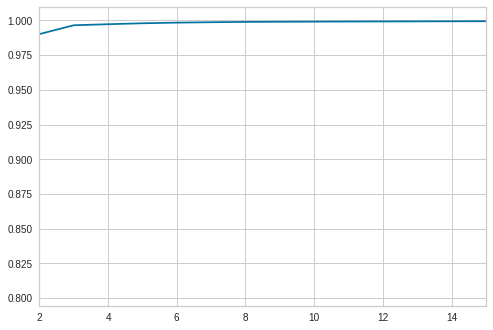

In [ ]:
#dim reduc PCA:
import numpy as np
from sklearn.decomposition import PCA
# Your code goes here
pca = PCA()
pca.fit(x_train)

pc_vs_variance = np.cumsum(pca.explained_variance_ratio_)

pc_vs_variance
plt.plot(pc_vs_variance)
plt.xlim([2, 15])
# so let's use 12 components

Now in order to scale the data and avoid multicollinearity we should use PCA, standard scale, and logistic regression all together in a pipeline. 

As done in homework/lecture, create a simple Logistic Regression model with a pipeline, fit it with the train data, and make predictions using the x test set. Note that the default logistic regression penalty is L2, so we should check Elastic Net and L1 later to see if they're any better!


In [ ]:
#linear regression using sklearn:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
scl = StandardScaler()
pca = PCA(n_components=12)

regr = LogisticRegression(max_iter=4000)
pipe = Pipeline(steps=[("scale",scl),("PCA",pca),("LogReg",regr)])
pipe.fit(x_train, y_train)


Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('PCA',
                 PCA(copy=True, iterated_power='auto', n_components=12,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('LogReg',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=4000,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

Now we use sklearn metrics to examine the logistic regression score and log_loss (cross-entropy really) values for the predictions made above. We find that they are both pretty good actually, with log loss being somewhat small and accuracy actually very high, so we already have a model that predicts accident severity based on features decently well.

Note: we *must* use cross-entropy loss for classification and logistic regression as well, linear regression and RMSE or R2 would be very bad and not actually give us the results we are looking for when our goal is multi-class classification.

In [ ]:
# check MSE on predictions above to see how model performs:
from sklearn.metrics import log_loss, accuracy_score

y_pred = pipe.predict(x_test)
prob_pred = pipe.predict_proba(x_test)
ll = log_loss(y_test, prob_pred)
score = accuracy_score(y_pred, y_test)
print(ll, score)




0.2665345609450631 0.9408853406029922


## Predicting Severity Using Simple Logistic Regression with Spark, Tuned for Comparing Models (L1, L2, Elastic Net, and Random Forest)

In this section we use a variety of semi-simple Spark models (logistic regression mostly) to make predictions using our data split into train and test sets in a similar way as above. Severity is still our category we are predicting, and the rest of the weather-related attributes are all of the features we have available. We see that we get very good Cross-Entropy Loss, accuracy, and other measures by the very end, and we also make conclusions about different models and parameters based on their outputs below.

(for example, we see L2 regression is best out of L1, L2 and Elastic Net because we must have some multicollinearity in our data and we may want to prevent overfitting)

### Spark Setup for Simple Logistic Regression Analysis

Install all of the necessary packages!

In [ ]:
!apt install libkrb5-dev
!wget https://www-us.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install findspark
!pip install sparkmagic
!pip install pyspark
!pip install pyspark --user
!pip install seaborn --user
!pip install plotly --user
!pip install imageio --user
!pip install folium --user

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libkrb5-dev is already the newest version (1.16-2ubuntu0.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 69 not upgraded.
--2021-05-06 01:25:39--  https://www-us.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
Resolving www-us.apache.org (www-us.apache.org)... 207.244.88.140
Connecting to www-us.apache.org (www-us.apache.org)|207.244.88.140|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://downloads.apache.org/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz [following]
--2021-05-06 01:25:40--  https://downloads.apache.org/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
Resolving downloads.apache.org (downloads.apache.org)... 135.181.214.104, 135.181.209.10, 88.99.95.219, ...
Connecting to downloads.apach

In [ ]:
!apt update
!apt install gcc python-dev libkrb5-dev

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:13 http://ppa.launchpad.net/graph

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F

import os

spark = SparkSession.builder.appName('ml-proj').getOrCreate()

In [ ]:
%load_ext sparkmagic.magics
#graph section
import networkx as nx
# SQLite RDBMS
import sqlite3
# Parallel processing
# import swifter
import pandas as pd
# NoSQL DB
from pymongo import MongoClient
from pymongo.errors import DuplicateKeyError, OperationFailure

import os
os.environ['SPARK_HOME'] = '/content/spark-2.4.5-bin-hadoop2.7'
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
import pyspark
from pyspark.sql import SQLContext

In [ ]:
try:
    if(spark == None):
        spark = SparkSession.builder.appName('Initial').getOrCreate()
        sqlContext=SQLContext(spark)
except NameError:
    spark = SparkSession.builder.appName('Initial').getOrCreate()
    sqlContext=SQLContext(spark)

Load the weather csv that was saved in the above section, use show() to make sure it updates and to see some of the rows.

In [ ]:
train_sdf = spark.read.csv("weather.csv", inferSchema=True, header=True)
train_sdf.show()

+---+--------+-------------------+--------------+-------------+-----------+------------+--------------+---------------+-----------------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+--------------------+-------------------+----------------+------------------+------------------+-------------------+----------------+-----------------+------------------+------------------+-----------------+--------------------+----------------+-----------------+------------------+------------------+-----------------+--------------------+------------------+-----------------------+----------------+------------------+------------------+-------------------+------------------------------+--------------------------------------+-----------------------+------------------------+--------------------------------+-------------------------+---------------------------------+----------------------+------------------------------+----

### Perform the Logistic Regression

Here we get rid of the index column and then create a vector assembler so that we can use a pyspark pipeline to transform our data. This makes it so we can easily define our label (severity) and features and then split into train and test sets.

In [ ]:
from pyspark.ml.feature import StringIndexer, VectorAssembler

drop_cols = ['_c0']
columns_to_use = [i for i in train_sdf.columns if i not in drop_cols]

assembler = VectorAssembler(inputCols=columns_to_use, outputCol='features')

Create the pipeline here, where out only stage is the vector assembler from above. Fit and transform the train_sdf so it is ready to use below in splitting and then the following models.

In [ ]:
from pyspark.ml import Pipeline
# Your code goes here
pipe = Pipeline(stages=[assembler])
modified_data_sdf = pipe.fit(train_sdf).transform(train_sdf)

Split the data for training and testing - training data allows us to train the model as we use 80% of the data there, and then we use the 20% to test our training of the model and we evaluate our predictions.

In [ ]:
train_sdf, test_sdf = modified_data_sdf.randomSplit([0.8, 0.2])
train_sdf.show()

+---+--------+-------------------+--------------+-------------+-----------+------------+--------------+---------------+-----------------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+--------------------+-------------------+----------------+------------------+------------------+-------------------+----------------+-----------------+------------------+------------------+-----------------+--------------------+----------------+-----------------+------------------+------------------+-----------------+--------------------+------------------+-----------------------+----------------+------------------+------------------+-------------------+------------------------------+--------------------------------------+-----------------------+------------------------+--------------------------------+-------------------------+---------------------------------+----------------------+------------------------------+----

Now what we want to do is start with a PySpark Logistic Regression (again needed because we have multi-class classification) so that we can compare it to the above logistic regression in sklearn and later more complex models. First we note which columns are features and which is the label (any that are not Severity and Severity respectively), and then we fit the LR model with the train spark dataframe.

After fitting the model, we get the summary of the model and see that it has FPR = 0.0 and accuracy, FPR, recall, and precision = 1.0 which are all (too) perfect. This means we should check for overfitting to make sure the model is not too closely fit to our train data.

In [ ]:
# now do linear regression 
from pyspark.ml.classification import LogisticRegression

features = modified_data_sdf
lr = LogisticRegression(featuresCol='features', labelCol='Severity')
lr_model = lr.fit(train_sdf)

In [ ]:
# view summary 
trainingSummary = lr_model.summary
print("FPR: %f" % trainingSummary.weightedFalsePositiveRate)
print("TPR: %f" % trainingSummary.weightedTruePositiveRate)
print("Precision: %f" % trainingSummary.weightedPrecision)
print("Recall: %f" % trainingSummary.weightedRecall)
print("Accuracy: %f" % trainingSummary.accuracy)

FPR: 0.000064
TPR: 0.999992
Precision: 0.999992
Recall: 0.999992
Accuracy: 0.999992


Check for overfitting as we did in lecture/homework, first we need to evaluate our model by making predictions using our model on our test set, make a regression evaluator with the prediction and label columns as defined by the model, and make sure to check the accuracy and possibly one or two other metrics of the model (many possible metrics like FPR, TPR, and recall, choose a couple). We use evaluate and find that the accuracy is VERY high, and perhaps it is too high and we can get good results with our model with a bit less complexity (i.e. we may have overfitting and not need such a tightly fit model). We see the same with a tiny FPR and high recall/precision.

In [ ]:
#check for overfitting:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

predictions = lr_model.transform(test_sdf)
eval = MulticlassClassificationEvaluator(labelCol="Severity", predictionCol="prediction", metricName="accuracy")
acc = eval.evaluate(predictions)
print(acc)
eval2 = MulticlassClassificationEvaluator(labelCol="Severity", predictionCol="prediction", metricName="weightedFalsePositiveRate")
FPR = eval2.evaluate(predictions)
print(FPR)
eval3 = MulticlassClassificationEvaluator(labelCol="Severity", predictionCol="prediction", metricName="weightedRecall")
rec = eval3.evaluate(predictions)
print(rec)

0.9999192180305356
1.299619635149425e-06
0.9999192180305355


Here we should use Lasso, Ridge, and Elastic Net regularization to improve the overfitting and complexity of our model. We use L1 by setting the Elastic Net parameter to 1, L2 by setting it to 0, and a combination of both (Elastic Net) by setting it to a value of 0.8 which seems to work fine. 

We then make a new LR model for each case and fit the train data, make predictions using the test set, and make another evaluator object in the same way as above to check the accuracy of each modified model. 

In [ ]:
# regularize to avoid overfittinga, trying lasso, ridge, and elastic net to see which is best:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

features = modified_data_sdf
l1 = LogisticRegression(featuresCol='features', labelCol='Severity', maxIter=10, regParam=.3, elasticNetParam=1)
l1_model = l1.fit(train_sdf)
prediction = l1_model.transform(test_sdf)
eval = MulticlassClassificationEvaluator(labelCol="Severity", predictionCol="prediction", metricName="accuracy")
acc = eval.evaluate(predictions)
print("L1:")
print(acc)
eval2 = MulticlassClassificationEvaluator(labelCol="Severity", predictionCol="prediction", metricName="weightedFalsePositiveRate")
FPR = eval2.evaluate(predictions)
print(FPR)
eval3 = MulticlassClassificationEvaluator(labelCol="Severity", predictionCol="prediction", metricName="weightedRecall")
rec = eval3.evaluate(predictions)
print(rec)

features = modified_data_sdf
l2 = LogisticRegression(featuresCol='features', labelCol='Severity', maxIter=10, regParam=.3, elasticNetParam=0)
l2_model = l2.fit(train_sdf)
prediction = l2_model.transform(test_sdf)
eval = MulticlassClassificationEvaluator(labelCol="Severity", predictionCol="prediction", metricName="accuracy")
acc = eval.evaluate(predictions)
print("L2:")
print(acc)
eval2 = MulticlassClassificationEvaluator(labelCol="Severity", predictionCol="prediction", metricName="weightedFalsePositiveRate")
FPR = eval2.evaluate(predictions)
print(FPR)
eval3 = MulticlassClassificationEvaluator(labelCol="Severity", predictionCol="prediction", metricName="weightedRecall")
rec = eval3.evaluate(predictions)
print(rec)

features = modified_data_sdf
en = LogisticRegression(featuresCol='features', labelCol='Severity', maxIter=10, regParam=.3, elasticNetParam=.8)
en_model = en.fit(train_sdf)
prediction = en_model.transform(test_sdf)
eval = MulticlassClassificationEvaluator(labelCol="Severity", predictionCol="prediction", metricName="accuracy")
acc = eval.evaluate(predictions)
print("Elastic Net:")
print(acc)
eval2 = MulticlassClassificationEvaluator(labelCol="Severity", predictionCol="prediction", metricName="weightedFalsePositiveRate")
FPR = eval2.evaluate(predictions)
print(FPR)
eval3 = MulticlassClassificationEvaluator(labelCol="Severity", predictionCol="prediction", metricName="weightedRecall")
rec = eval3.evaluate(predictions)
print(rec)



L1:
0.9999192180305356
1.299619635149425e-06
0.9999192180305355
L2:
0.9999192180305356
1.299619635149425e-06
0.9999192180305355
Elastic Net:
0.9999192180305356
1.299619635149425e-06
0.9999192180305355


So we see from above that the each still does very well in predicting the classification desired. There are two reasons this could be: First, it could be that the model is still overfitting, even though we tested multiple versions of the model with different regularization, iterations, and the regparam as we have hypertuned in the past. It could also be that the data (and our classes) are easily predicted by the features we have on hand. We will now move on to different models to test their capabilities compared to these, but a possible future direction would be exploring the above logistic regression with less features or more regularization to see if it really is easy to predict or if we are currently overfitting.

Now another kind of regularization and regression we will do is the Random Forest from PySpark. Do this to hopefully reduce overfitting as well, and follow much of the same process as above. Create the model, fit the train sdf, make predictions on the train and test set. When we evaluate using accuracy, recall, and precision again, we see that again all are very close to 1.0, which is technically good! This means the random forest is also very good at predicting our classes, though it is possible that it still has the problem of overfitting as discussed above.

In [ ]:
# do random forest regression to see if it's any better:
from pyspark.ml.regression import RandomForestRegressor
features = modified_data_sdf
rf = RandomForestRegressor(featuresCol="features", labelCol='Severity')
rf_model = rf.fit(train_sdf)

In [ ]:
# make predictions and evaluate:
predictionTr = rf_model.transform(train_sdf)
predictionTe = rf_model.transform(test_sdf)

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
eval = MulticlassClassificationEvaluator(labelCol="Severity", predictionCol="prediction", metricName="accuracy")
acc = eval.evaluate(prediction)
print(acc)
eval2 = MulticlassClassificationEvaluator(labelCol="Severity", predictionCol="prediction", metricName="weightedPrecision")
prec = eval2.evaluate(prediction)
print(prec)
eval3 = MulticlassClassificationEvaluator(labelCol="Severity", predictionCol="prediction", metricName="weightedRecall")
rec = eval3.evaluate(prediction)
print(rec)

# they are all high (perfect actually)

0.9412715081993699
0.8859920521479164
0.9412715081993699


In [ ]:
# extra code for cleanup earlier
# train_sdf = train_sdf.drop("pcaFeatures")
# test_sdf = test_sdf.drop("pcaFeatures")

### PCA and LR to Compare to Above

For our final regression model in the PySpark section, we will use PCA to reduce dimensionality and complexity and evaluate a new linear regression model and check the results against the above models.

We first use the PCA number of components (k=12) found above, select the correct input and output columns, and fit the PCA model on the train set. Then we transform thetest and train sets using the PCA model and select their features. Finally we use an elastic net logistic regression and fit the train sdf, and then make predictions on the train and test sets.

We use evaluators as above and check the accuracy, and we find that find that both values are very very close to 1. This is very small so could be due to overfitting, but both train and test accuracy are very high so it could be that our model just predicts the features very well.

In [ ]:
# PCA for dimensionality reduction:
from pyspark.ml.feature import PCA
# num features from way before
train_sdf = train_sdf.drop("pcaFeatures")
test_sdf = test_sdf.drop("pcaFeatures")
pca = PCA(k=12, inputCol="features", outputCol='pcaFeatures')
pca_model = pca.fit(train_sdf)

train_sdf = pca_model.transform(train_sdf)
train_feat = train_sdf.select('Severity', 'pcaFeatures')

test_sdf = pca_model.transform(test_sdf)
test_feat = test_sdf.select('Severity', 'pcaFeatures')


lr_new = LogisticRegression(featuresCol='pcaFeatures', labelCol='Severity', regParam=.3, elasticNetParam=.8)
lr_model_new = lr.fit(train_sdf)

pred1 = lr_model_new.transform(train_sdf)

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
eval = MulticlassClassificationEvaluator(labelCol="Severity", predictionCol="prediction", metricName="accuracy")
acc = eval.evaluate(pred1)
print("Training Evaluation:")
print(acc)
eval2 = MulticlassClassificationEvaluator(labelCol="Severity", predictionCol="prediction", metricName="weightedPrecision")
prec = eval2.evaluate(pred1)
print(prec)
eval3 = MulticlassClassificationEvaluator(labelCol="Severity", predictionCol="prediction", metricName="weightedRecall")
rec = eval3.evaluate(pred1)
print(rec)


Training Evaluation:
0.9999918776118555
0.9999918776118554
0.9999918776118554


Check a couple results - they look good!

In [ ]:
pred1.select("prediction", "Severity", "features").show(5)

+----------+--------+--------------------+
|prediction|Severity|            features|
+----------+--------+--------------------+
|       2.0|       2|(97,[0,1,2,3,4,5,...|
|       2.0|       2|(97,[0,1,2,3,4,5,...|
|       2.0|       2|(97,[0,1,2,3,4,5,...|
|       2.0|       2|(97,[0,1,2,3,4,5,...|
|       2.0|       2|(97,[0,1,2,3,4,5,...|
+----------+--------+--------------------+
only showing top 5 rows



In [ ]:
# predictions from PCA one:
predictions = lr_model_new.transform(test_sdf)
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
eval = MulticlassClassificationEvaluator(labelCol="Severity", predictionCol="prediction", metricName="accuracy")
acc = eval.evaluate(predictions)
print("Testing Evaluation:")
print(acc)
eval2 = MulticlassClassificationEvaluator(labelCol="Severity", predictionCol="prediction", metricName="weightedPrecision")
prec = eval2.evaluate(predictions)
print(prec)
eval3 = MulticlassClassificationEvaluator(labelCol="Severity", predictionCol="prediction", metricName="weightedRecall")
rec = eval3.evaluate(predictions)
print(rec)
# results: we have very high accuracy here which is good but may be overfittin


Testing Evaluation:
0.9999192180305356
0.9999196280912942
0.9999192180305355


Check predicted results too - these also look good!

In [ ]:
predictions.select("prediction", "Severity", "features").show(5)

+----------+--------+--------------------+
|prediction|Severity|            features|
+----------+--------+--------------------+
|       2.0|       2|(97,[0,2,3,4,5,6,...|
|       2.0|       2|(97,[0,1,2,3,4,5,...|
|       3.0|       3|(97,[0,1,2,3,4,5,...|
|       2.0|       2|(97,[0,1,2,3,4,5,...|
|       2.0|       2|(97,[0,1,2,3,4,5,...|
+----------+--------+--------------------+
only showing top 5 rows



##PyTorch Neural Networks to Compare to Spark

In this last section of the weather analysis part of the project, we will create two neural network models to see how they perform on predicting the severity with the same features as the above sections. These are more complex than the above models and should perform well (as the others performed well already) and thus we should expect to see high accuracy and very low loss.

### Data setup and initialization

Import necessary packages and functions, use GPU if necessary later, save it as a variable device.

In [ ]:
# finally, do a neural network for more complex analysis - to check if this is better than the above methods:
# do simple vs feed forward neural net, want to compare pytorch and the above spark models
import torch
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import make_grid
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Use the modified data sdf from above, send to pandas first so then we can make torch tensors from the parts of the pandas dataframe. Again the label we are hoping to predict is an accident's severity, and the features are all of the other columns. We then make torch tensors from both.

In [ ]:
pandas = modified_data_sdf.toPandas()
label = pandas["Severity"]

data = pandas.loc[:, pandas.columns != 'Severity']
labels = torch.tensor(label)
# need to drop features column from above so we can convert to tensor, features is vectors from above and not needed here
data = data.drop(labels="features", axis=1)
# source for conversion: https://stackoverflow.com/questions/50307707/convert-pandas-dataframe-to-pytorch-tensor
data = torch.tensor(data.values)


Now create a torch Tensor Dataset and then random split ~80% ~20% the data into train and test sets. Finally, make a train loader as we did in lecture and homework from the train set with a batch size of 32, and a test loader with the default batch size.

In [ ]:
# make dataset, train and test loaders etc:
dataset = TensorDataset(data, labels)
train_set, test_set = torch.utils.data.random_split(dataset, [246502, 61626])
train_loader = DataLoader(train_set, batch_size=32)
test_loader = DataLoader(test_set)

Setup the variables for the simple NN model below - we want 97 features as that is how many columns our SDF had besides the label, we choose the number for our hidden layers to be 20, anything generally close to 20 works. Finally we choose to train for 10 epochs. This value was chosen after multiple testing rounds/hyperparameter tuning tests on the model below - the loss and accuracy bottom out and stop changing around 7-8 epochs and 10 is just a good number to make sure they will not change too much any more.

In [ ]:
# from the data, batch_x.shape gave 97 features
num_features = 97
# choose and maybe tune later
num_hidden = 20
num_epochs = 10

### Simple Neural Network Setup, Training, and Evaluation

Our first neural network is a simple neural network, which features a couple linear and ReLU layers. It uses a cross entropy loss function (in the train function below) and an Adam optimizer for the usual backward() and gradient descent, with a learning rate of 1e-4.

In [ ]:
# simple nn first:
simple_net = nn.Sequential(
    nn.Linear(num_features, num_hidden),
    nn.ReLU(),
    nn.Linear(num_hidden, num_hidden),
    nn.ReLU(),
    nn.Linear(num_hidden, 97)
)
optim = torch.optim.Adam(simple_net.parameters(), lr=0.0001)

Now we define our model training function, where we are able to do the necessary steps of training a neural network. First we define a cross entropy loss function (which we need to use because we are performing classification), set the loss function and optimizer, and set the input model to trianing mode. 

We then itetate for the desired number of epochs, iterate through each of the batches in the train loader in each epoch, and perform the usual optimizer and loss steps. 

Throughout this process we record accuracy and loss so that we can see how the model is training and plot them to view model performance. 

In [ ]:
# model training fxn
def train_model(net):
  loss_fn = nn.CrossEntropyLoss()
  
  optim = torch.optim.Adam(net.parameters(), lr=0.0001)
  # set the model to training
  net.train()
  for i in range(num_epochs):
    epoch_loss = []
    epoch_acc = []

    for batch_x, batch_y in train_loader:
      # zero out the gradients
      optim.zero_grad()
      # get the neural net's current prediction
      pred = net(batch_x.float())
      # calculate the loss for this prediction
      loss = loss_fn(pred, batch_y.long())
      # backprop the loss
      loss.backward()
      epoch_loss.append(loss.item())
      # use the gradients to update the model's weights
      optim.step()
      #print(pred.shape)
      #print(batch_y.shape)
      pred_trans = torch.argmax(pred, 1)

      acc_list = (pred_trans == batch_y.float())
      trues = sum(acc_list)
      curr_accuracy = trues / len(batch_y)
      epoch_acc.append(curr_accuracy.item())

    loss_vals.append(sum(epoch_loss)/len(epoch_loss))
    print(sum(epoch_loss)/len(epoch_loss))
    acc_vals.append(sum(epoch_acc) / len(epoch_acc))
    print(sum(epoch_acc) / len(epoch_acc))

  final_training_accuracy = sum(epoch_acc) / len(epoch_acc) 
  final_training_loss = sum(epoch_loss)/len(epoch_loss) 
  return final_training_loss, final_training_accuracy

Here we view the final loss and accuracy. Both are very good! Next we graph loss and accuracy and see them start large and small respectively but improve a lot as we train which is what we hope for/expect with this kind of model.

In [ ]:
# train model and check output:
acc_vals = []
loss_vals = []
lr_train_loss, lr_train_acc = train_model(simple_net)
print("Logistic Regression - the training loss is ", str(lr_train_loss))
print("Logistic Regression - the training accuracy is ", str(lr_train_acc))


40.11869932499302
0.9075439706645898
1.3582515865243299
0.9148656542056075
1.2988070974150077
0.9169830607476636
1.2526809102637104
0.9174130321910696
1.2023085145870809
0.9170439057632399
1.1805564918949907
0.91819996105919
1.100663077892576
0.9184473974558671
1.0039195700918195
0.9204390576323987
1.0515441549971964
0.9199482411734164
0.9959307335452292
0.9209582684319834
Logistic Regression - the training loss is  0.9959307335452292
Logistic Regression - the training accuracy is  0.9209582684319834


In our graphs we see that loss and accuracy improve to near perfect after 1-2 epochs. This is rare in the real world but it is very possible that the first epoch trained our model enough to do well on the rest of the data in later epochs. We used a small learning rate and it could be that the data examined in the first epoch allowed our model to learn the important thing necessary to accurate prediction in the first epoch. It is also possible (or even expected) that a lot of our data entries (for example, mildly severe accidents with basic weather conditions) are VERY similar and thus the model may predict them very well.

It could also be that our batch size is so small that the model is trained enough in the first epoch or two, and we could increase this to speed up the model and still achieve a good accuracy/loss result. However the model is fast enough at the moment and does very well so we leave it at 32.

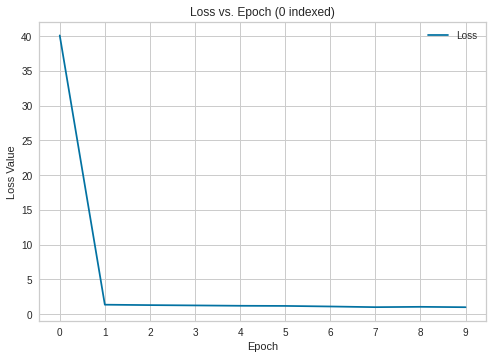

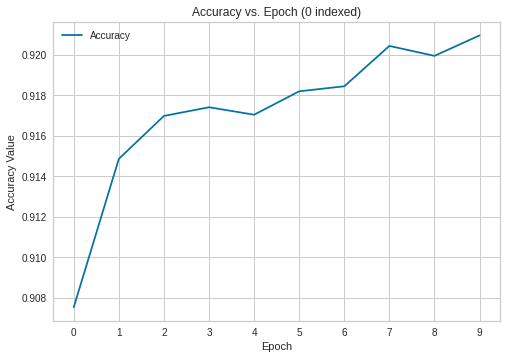

In [ ]:
# now graph loss and acc vs epoch
y1 = loss_vals
x = list(range(10))
plt.plot(x, y1, label = "Loss")
plt.xticks(x)
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.title('Loss vs. Epoch (0 indexed)')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()


y2 = acc_vals
plt.plot(x, y2, label = "Accuracy")
plt.xticks(x)
plt.xlabel('Epoch')
plt.ylabel('Accuracy Value')
plt.title('Accuracy vs. Epoch (0 indexed)')
plt.legend()
plt.show()

Now we write a test model function to see how our model performs on the test set that was split from earlier. We set the model to evaluation, use the same loss function, and iterate over the batches in the test loader this time until we have tested all of them with our model (using predict and loss again).

We again keep track of loss and accuracy and report the final values of each - we find that both are very good again - similar to when we trained the model. As a result we see our model does very well predicting the severity of an accident.

In [ ]:
# evaluate model with test model:
def test_model(model):
    model.eval()
    loss_fn = nn.CrossEntropyLoss()

    # TODO: Implement your testing loop with the `test_loader` data
        # source: lecture videos and recitation
    epoch_loss = []
    epoch_acc = []

    for batch_x, batch_y in test_loader:
      # zero out the gradients
      # get the neural net's current prediction
      pred = model(batch_x.float())
      # calculate the loss for this prediction
      loss = loss_fn(pred, batch_y.long())
      # backprop the loss

      epoch_loss.append(loss.item())

      pred_trans = torch.argmax(pred, 1)

      acc_list = (pred_trans == batch_y.float())
      trues = sum(acc_list)
      curr_accuracy = trues / len(batch_y)
      epoch_acc.append(curr_accuracy.item())


    final_test_acc = sum(epoch_acc) / len(epoch_acc) 
    final_test_loss = sum(epoch_loss)/len(epoch_loss) 
    return final_test_loss, final_test_acc

In [ ]:
lr_testing_loss, lr_testing_acc = test_model(simple_net)

print("Logistic Regression - the testing loss is ", str(lr_testing_loss))
print("Logistic Regression - the testing accuracy is ", str(lr_testing_acc))

Logistic Regression - the testing loss is  2.3078343352118456
Logistic Regression - the testing accuracy is  0.9391490604614935


Note: we see above that while our model does well, it is not perfect. This model, however, is likely more complex and effective at what we want to achieve than the models in sklearn or spark from above. Those models are possibly overfitting and performing unnecessary work, whereas in this model we can see exactly what it is doing, how it is doing it (in terms of accuracy and loss calculations), and it is somewhat reassuring that our model is not perfect in that we know we are doing well but not too well. 

Because this model does very well in terms of accuracy and loss, it is a reasonable possibility that our classes are easy to predict given the features we are using (as discussed above in the sklearn/spark secction). This would make sense given the above logistic regression did VERY (or too) well, and our accuracy is very high using even a simple neural network.

### FeedForward Neural Network Setup, Training, and Evaluation

Now what we want to do is try a little more complex model to see if the loss or accuracy can get any better. We do this to emulate what we did in class and lecture, to compare the two model types, and make an attempt at improving the above (albeit already very good) simple neural network model.

Here we define a feedforward neural net with input size 97 as that is how many features we have and hidden size 32 just to work between input and output dimensions, and then output size being 4 for our 4 possible classes of severity. This model is very similar to what we did in class and should work well (being a little more complex) than the above simple net. We also stil lhave the mini-batch size of 32 which clearly good enough to create good accuracy and loss. It does not make the model too slow as well so we keep 32 (as opposed to increasing to improve speed/efficiency) and get good results.

In [ ]:
# the above is really good! see if FNN does any better:
class Feedforward(torch.nn.Module):
        def __init__(self, input_size, hidden_size):
            super(Feedforward, self).__init__()
            self.input_size = input_size
            self.hidden_size  = hidden_size
            
            self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
            self.relu = torch.nn.ReLU()
            self.fc2 = torch.nn.Linear(self.hidden_size, self.hidden_size)
            self.fc3 = torch.nn.Linear(self.hidden_size, self.hidden_size)
            self.fc4 = torch.nn.Linear(self.hidden_size, 4)

        def forward(self, x):
            hidden1 = self.fc1(x)
            relu = self.relu(hidden1)
            output1 = self.fc2(relu)
            relu2 = self.relu(output1)
            output2 = self.fc3(relu2)
            relu3 = self.relu(output2)
            output3 = self.fc4(relu3)

            return output2

fnn_model = Feedforward(97, 32)

Here we train the model in the same way as with the simple neural net and view our training results. They are almost exactly the same as what was found in the simple neural net and we will discuss this below.

In [ ]:
acc_vals = []
loss_vals = []
fnn_optimizer =  torch.optim.Adam(fnn_model.parameters(), lr = 1e-4)
fnn_training_loss, fnn_training_accuracy = train_model(fnn_model)

print("Feedforward Neural Network - the training loss is ", str(fnn_training_loss))
print("Feedforward Neural Network - the training accuracy is ", str(fnn_training_accuracy))

15.393636713597019
0.8920406606957425
2.0086113840820072
0.9030941718587746
1.8809065898382822
0.9037431853582555
1.8354552985514323
0.9048749026479751
1.6173329385346213
0.9064217181557157
1.4611128371187034
0.9092598001038421
1.4731669405153827
0.9082538291796469
1.2774527168627785
0.9118558541017653
1.1723073821112293
0.9122696002076843
1.082790105859267
0.9147885838525441
Feedforward Neural Network - the training loss is  1.082790105859267
Feedforward Neural Network - the training accuracy is  0.9147885838525441


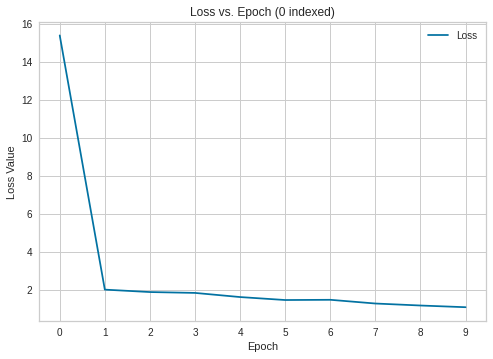

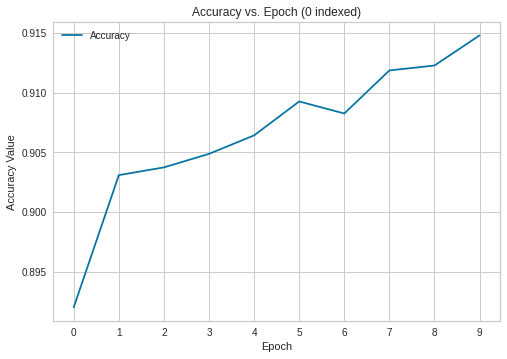

In [ ]:
# now graph loss and acc vs epoch
y1 = loss_vals
x = list(range(10))
plt.plot(x, y1, label = "Loss")
plt.xticks(x)
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.title('Loss vs. Epoch (0 indexed)')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()


y2 = acc_vals
plt.plot(x, y2, label = "Accuracy")
plt.xticks(x)
plt.xlabel('Epoch')
plt.ylabel('Accuracy Value')
plt.title('Accuracy vs. Epoch (0 indexed)')
plt.legend()
plt.show()

Here we see we get very similar results to the simple neural net that we built above, except that loss is a little higher and accuracy just a little lower. In effect we get very good accuracy and loss values in a small number of epochs, and they both level off at similar values as the other neural network. This one is a little worse probably because we could benefit from using a few more epochs. However we reach similar results when training with 10 epochs each so this is not a large concern.

We next perform testing using the fnn model and see new results:


In [ ]:
# testing on FNN to see result vs simple model?
fnn_testing_loss, fnn_testing_acc = test_model(fnn_model)

print("Logistic Regression - the testing loss is ", str(fnn_testing_loss))
print("Logistic Regression - the testing accuracy is ", str(fnn_testing_acc))

Logistic Regression - the testing loss is  1.0292294259813088
Logistic Regression - the testing accuracy is  0.9391652873787038


Here we see that we have similar testing accuracy as the simple model but that the testing loss is even lower than before. This is a good result, and we can conclude that this fnn model does even better at predicting severity than the simple nn model does. However, they are both very close and similar, so both work well and both are efficient (i.e. we can choose either).

There is still a small concern of overfitting, though the above results look good. In the future, we could reduce model complexity and choose either a new model or the simple neural net we have already created. The simple neural net has very good (and similar) training and test accuracy/loss, so it is clear that the classes we have can be predicted relatively easily using our feature set (i.e. we do not need an unnecessarily complex model to reach good conclusions). 

##Section Conclusion:


In this section we did varying degrees of analysis on the weather-focused attributes of our accident dataset. We began with some data cleaning that was necessary to select and transform some of the features we wanted to observe and make sure we had enough (but not too many) observations to work with. We then transitioned into simple aggregate measure and plotting to get a general idea of the trends in our data. As such we saw relationships between pairs of features and graphed our main variable we wanted to predict (accident severity) versus a couple features to see how they impacted the accident severity (very surface level but still valiable to see). Next, we examined weather conditions in relation to some of the features and did some log transformations and smoothing to make our data more visually appealing.

After visualizing our data and making conclusions we moved into regression analysis through Sci-kit Learn and Spark. We used logistic regression to train models to classify accidents into one of the four categories of severity. All of the weather features were turned into one-hot vectors so everything was numerical and then we were able to perform regularization, scaling, dimensionality reduction, and different types of logistic regression as done in class. 

We found that the logistic regression models performed very well with hiagh accuracy and low error in any given regularization situation. This could be indicative of overfitting, so we would probably need to try more in-depth hyperparameter tuning or possibly use other methods not learned in class to address this problem. There is also a decent chance the models are not overfitting, but that they are just performing well and that the data is easily classified/predicted. This hypothesis is supported by the strong accuracy and low loss of the PyTorch models that were done afterwards, where a simple neural network performed very well with our train and test data.

Finally, we created two different Neural Networks in PyTorch, a simple neural net with two linear layers and a more complex feed-forward neural network with two hidden layers. It turned out that the feed-forward network had high training performance and low loss but potentially overfit on the test set, while the simple model performed well on both the train and test sets. As a result it seems that the FFN had a little overfitting and that the data was predicted relatively easily with a simple neural network.

Overall it was very iteresting to see the trends in the data from a weather-oriented perspective, and it was also exciting to create different models for the same purpose of predicting severity based on 97 weather-related features.


********************************

# ***Beginning of Location Analysis***

In this section we will be performing many different kinds of analysis on many levels with the goal of investigating trendsin location from the accident data. We will begin with geopandas and location visualization, and will then move into linear regression and more complex models to build a model....[EDIT THIS]

In [ ]:
dataset_to_use.head()

ID Source  ...  Nautical_Twilight  Astronomical_Twilight
2717489  A-2717612   Bing  ...                Day                    Day
2717490  A-2717613   Bing  ...                Day                    Day
2717491  A-2717614   Bing  ...                Day                    Day
2717492  A-2717615   Bing  ...              Night                  Night
2717493  A-2717616   Bing  ...              Night                  Night

[5 rows x 49 columns]

## Installing Packages and Preparing Data

To visualize where the crashes occur, we use a geopandas package to plot each latitude/longitude point. To do this, we import shapefiles of California and Washington (as those are the states we've decided to focus on), which we read into geopandas and plot on. 

First, to install geopandas and all packages necessary to plot the graphs, we do the following:

In [ ]:
%pip install geopandas

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

%matplotlib inline

Now, we import shapefiles downloaded from official US government data, showing the borders of each state and each county within the state. 

In [ ]:
us_map = gpd.read_file('/content/gdrive/MyDrive/545/cb_2018_us_nation_20m.shp')
ca_map = gpd.read_file('/content/gdrive/MyDrive/545/CA_State_TIGER2016.shp')
ca_counties_map = gpd.read_file('/content/gdrive/MyDrive/545/CA_Counties_TIGER2016.shp')
ca_tl_map = gpd.read_file('/content/gdrive/MyDrive/545/tl_2016_06_cousub.shp')
wa_tl_map = gpd.read_file('/content/gdrive/MyDrive/545/tl_2016_53_cousub.shp')

We'll be using the ca_t1_map and the wa_t1_map, which show the shapefiles for California and Washington, respectively. Now, we set a figure size of 15 by 15 and plot the two shapefiles to see what the data currently looks like. 

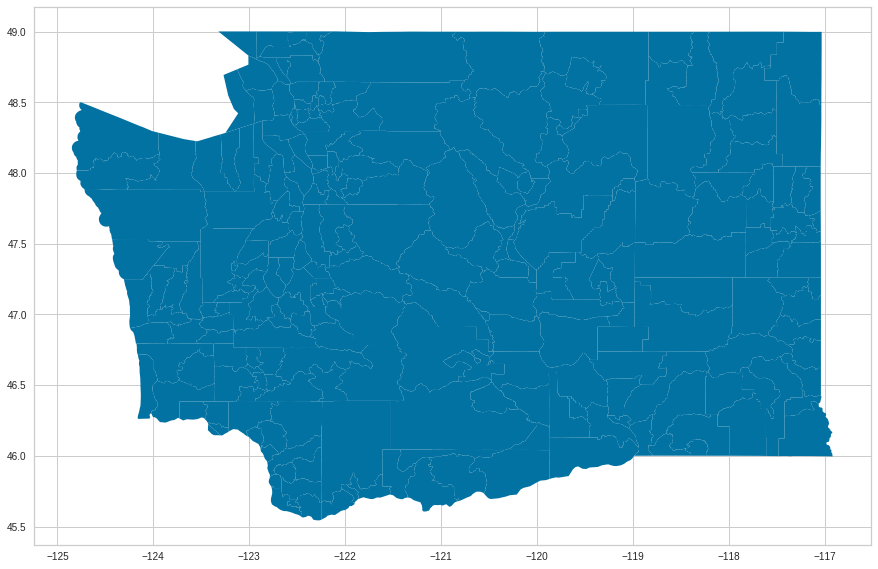

In [ ]:
fig,ax = plt.subplots(figsize = (15,15))
wa_tl_map.plot(ax = ax)

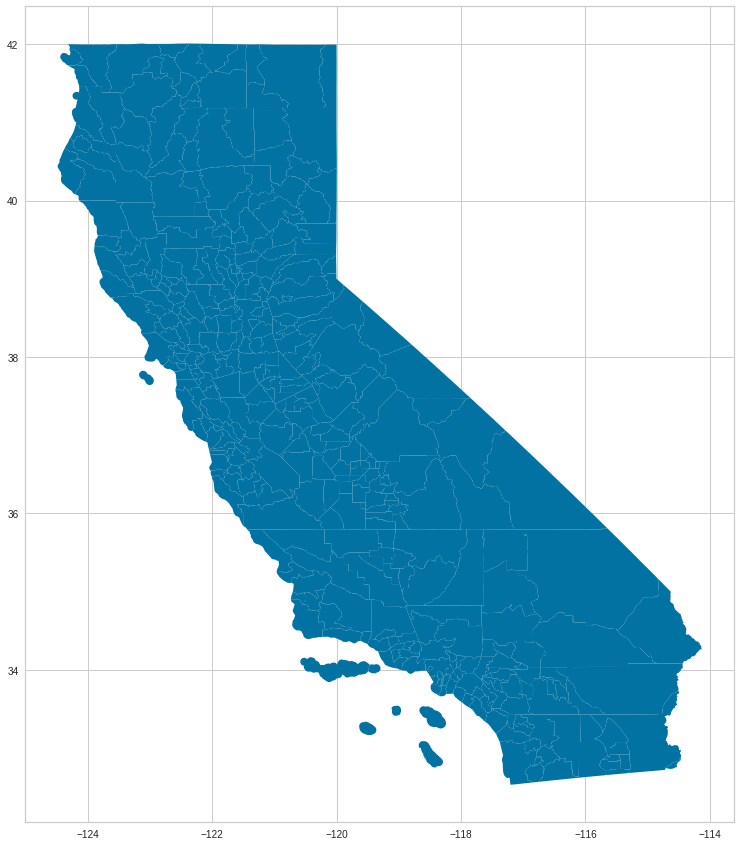

In [ ]:
fig,ax = plt.subplots(figsize = (15,15))
ca_tl_map.plot(ax = ax)

As you can see, currently the shapefiles showcase the two states with their borders and the borders of each county within the state. We'll first make a copy of the dataset that we'll use for convenience's sake. 

In [ ]:
copy_do_not_touch = dataset_to_use.copy()
copy_do_not_touch

ID Source  ...  Nautical_Twilight  Astronomical_Twilight
2717489  A-2717612   Bing  ...                Day                    Day
2717490  A-2717613   Bing  ...                Day                    Day
2717491  A-2717614   Bing  ...                Day                    Day
2717492  A-2717615   Bing  ...              Night                  Night
2717493  A-2717616   Bing  ...              Night                  Night
...            ...    ...  ...                ...                    ...
4232536  A-4239402   Bing  ...                Day                    Day
4232537  A-4239403   Bing  ...                Day                    Day
4232538  A-4239404   Bing  ...                Day                    Day
4232539  A-4239405   Bing  ...                Day                    Day
4232540  A-4239406   Bing  ...                Day                    Day

[471832 rows x 49 columns]

Then, we splt this dataset into two distinct dataframes– one with solely California data and one with solely Washington data. We designate dataset_to_use to be California data and dataset_to_use_wa to be Washington data. 

In [ ]:
dataset_to_use = copy_do_not_touch[copy_do_not_touch["State"]=="CA"]

In [ ]:
dataset_to_use_wa = copy_do_not_touch[copy_do_not_touch["State"]=="WA"]

Using geopandas and the packages imported earlier, we create Series called geometry and geometry_wa that include each (X,Y) point with X being the latitude and Y being the longitude. 

In [ ]:
geometry = [Point(xy) for xy in zip(dataset_to_use["Start_Lng"],dataset_to_use["Start_Lat"])]
geometry[:3]

In [ ]:
geometry_wa = [Point(xy) for xy in zip(dataset_to_use_wa["Start_Lng"],dataset_to_use_wa["Start_Lat"])]
geometry_wa[:3]

Then, we use geopandas to create a geoDataFrame called geo_df (for California data), which includes a column called geometry. Similarly, we create a geoDataFrame called geo_df_wa (for Washington data), which includes a column called geometry for the Washington latitude/longitude.

In [ ]:
crs = {'init':'epsg:4326'}
geo_df = gpd.GeoDataFrame(dataset_to_use, crs = crs, geometry = geometry)
geo_df.head()

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


ID Source  ...  Astronomical_Twilight                     geometry
2717489  A-2717612   Bing  ...                    Day  POINT (-120.02921 38.82584)
2717490  A-2717613   Bing  ...                    Day  POINT (-121.84002 37.35821)
2717491  A-2717614   Bing  ...                    Day  POINT (-122.30799 37.88194)
2717492  A-2717615   Bing  ...                  Night  POINT (-122.30779 37.88104)
2717493  A-2717616   Bing  ...                  Night  POINT (-121.10166 38.51881)

[5 rows x 50 columns]

In [ ]:
crs = {'init':'epsg:4326'}
geo_df_wa = gpd.GeoDataFrame(dataset_to_use_wa, crs = crs, geometry = geometry_wa)
geo_df_wa.head()

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


ID Source  ...  Astronomical_Twilight                     geometry
2827457  A-2827580   Bing  ...                    Day  POINT (-122.90599 47.01680)
2827467  A-2827590   Bing  ...                    Day  POINT (-123.90652 47.33212)
2827489  A-2827612   Bing  ...                    Day  POINT (-122.23119 47.88415)
2827514  A-2827637   Bing  ...                    Day  POINT (-122.19506 48.18813)
2827559  A-2827682   Bing  ...                    Day  POINT (-122.23119 47.88415)

[5 rows x 50 columns]

Using the geoDataFrames made earlier, we can plot the latitude and longitude points for each crash. We can split this into two types of crashes– those during the day, designated by blue, and those during the night, designated by red. We do this for both Washington and California. 

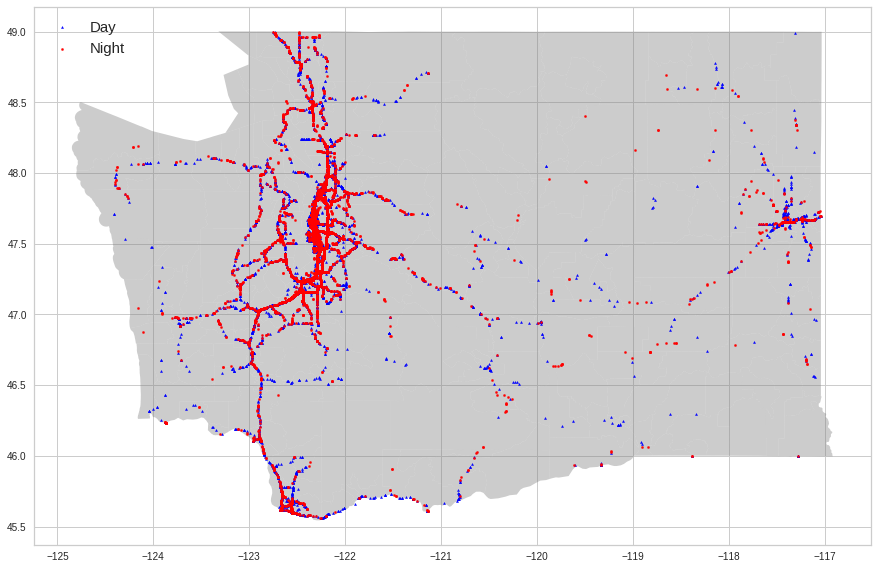

In [ ]:
fig,ax = plt.subplots(figsize=(15,15))
wa_tl_map.plot(ax = ax, alpha = 0.4, color = "grey")
#fig.subplots_adjust(left=0, bottom=0, right=5, top=5, wspace=0, hspace=0)
geo_df_wa[geo_df_wa["Sunrise_Sunset"]=="Day"].plot(ax=ax, markersize = 5, color = "blue", marker = "^", label = "Day")
geo_df_wa[geo_df_wa["Sunrise_Sunset"]=="Night"].plot(ax=ax, markersize = 5, color = "red", marker = "o",label = "Night")
plt.legend(prop={'size':15})

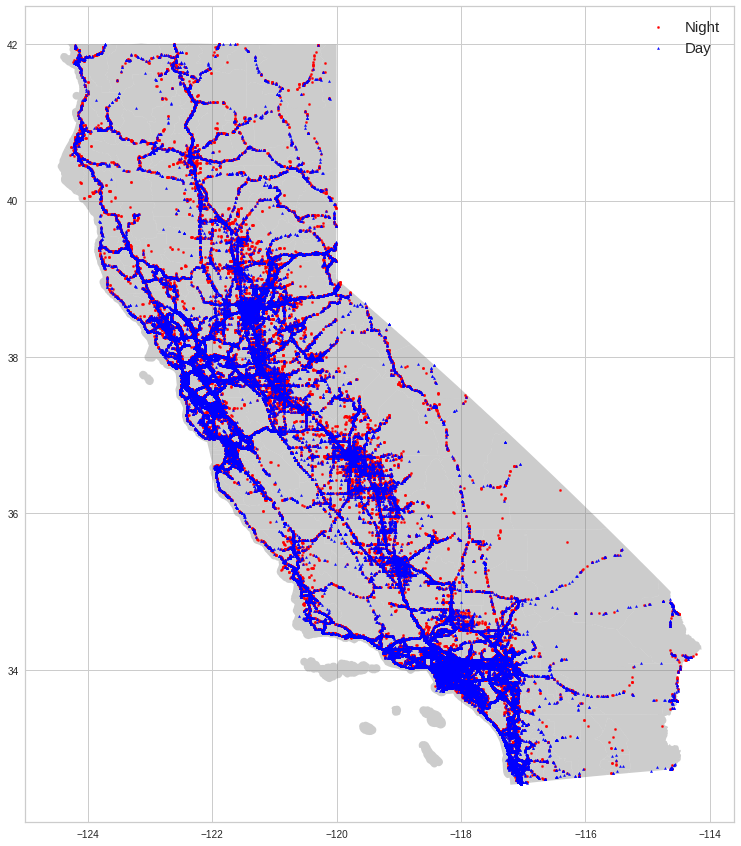

In [ ]:
fig,ax = plt.subplots(figsize=(15,15))
ca_tl_map.plot(ax = ax, alpha = 0.4, color = "grey")
#fig.subplots_adjust(left=0, bottom=0, right=5, top=5, wspace=0, hspace=0)
geo_df[geo_df["Sunrise_Sunset"]=="Night"].plot(ax=ax, markersize = 5, color = "red", marker = "o",label = "Night")
geo_df[geo_df["Sunrise_Sunset"]=="Day"].plot(ax=ax, markersize = 5, color = "blue", marker = "^", label = "Day")
plt.legend(prop={'size':15})

Now that we have a sense of what the data location looks like and where it is, we move onto modeling. 

## Setup data and use for simple sklearn regression analysis 

---

We'll be using each of the True/False variables, including Amenity, Bump, Crossing, Junction, No_Exit, Railway, etc to predict the severity of the accident. 

---



We'll still be using the dataset_to_use dataframe, but will need to one-hot-encode each of the T/F variables that will be used to predict the severity of the accident. 

In [ ]:
dataset_to_use.head()

ID Source  ...  Astronomical_Twilight                     geometry
2717489  A-2717612   Bing  ...                    Day  POINT (-120.02921 38.82584)
2717490  A-2717613   Bing  ...                    Day  POINT (-121.84002 37.35821)
2717491  A-2717614   Bing  ...                    Day  POINT (-122.30799 37.88194)
2717492  A-2717615   Bing  ...                  Night  POINT (-122.30779 37.88104)
2717493  A-2717616   Bing  ...                  Night  POINT (-121.10166 38.51881)

[5 rows x 50 columns]

To do this, we first drop the extraneous columns and create a list of columns to one-hot-encode. This is designated by "list_to_encode", and we iterate through each column name to one-hot-encode each of the variables. Then, we drop all of the non-float columns, and convert ZipCode to a purely numerical column by turning each zipcode into a 5 digit number rather than something of the form "12345-1234". Finally, we drop all NaN rows, and we're done, with 407647 rows to use. 

In [ ]:

tf_df = dataset_to_use.copy()

tf_df = tf_df.drop(columns=['ID','Start_Time','End_Time','End_Lat','End_Lng','Description','Number','Street','Side','Timezone','Airport_Code','Weather_Timestamp'])

list_to_encode = ["Amenity","Bump","Crossing","Give_Way","Junction","No_Exit","Railway","Roundabout",	"Station",	"Stop", "Traffic_Calming",	"Traffic_Signal",	"Turning_Loop",	"Sunrise_Sunset",	"Civil_Twilight",	"Nautical_Twilight",	"Astronomical_Twilight"]

for x in list_to_encode:
  tf_df[x] = tf_df[x].astype('category')
tf_df = pd.get_dummies(tf_df, columns=list_to_encode)


tf_df = tf_df.drop(columns=['Wind_Chill(F)','Precipitation(in)','Source','TMC','City','County','State','Country','Wind_Direction','Weather_Condition','geometry'])
tf_df['Zipcode'] = tf_df['Zipcode'].astype(str)
tf_df['Zipcode'] = tf_df['Zipcode'].apply(lambda x: x.split("-")[0] if "-" in x else x)

tf_df = tf_df.dropna()
tf_df

Severity  ...  Astronomical_Twilight_Night
2717491         3  ...                            0
2717492         2  ...                            1
2717493         2  ...                            1
2717494         2  ...                            1
2717495         2  ...                            1
...           ...  ...                          ...
4232536         2  ...                            0
4232537         2  ...                            0
4232538         2  ...                            0
4232539         2  ...                            0
4232540         2  ...                            0

[407647 rows x 43 columns]

We then make a copy of this for convenience's sake. 

In [ ]:
tf = tf_df.copy()

Here, we designate the label to be "Severity" and create a csv that will be used later. We then import the sklearn package and split up the data into 4 sections, and run PCA. 

In [ ]:
label_tf = tf["Severity"]
features_tf = tf.loc[:, tf.columns != 'Severity']
tf.to_csv('tf.csv')

In [ ]:
from sklearn.model_selection import train_test_split
xtf_train, xtf_test, ytf_train, ytf_test = train_test_split(features_tf, label_tf, test_size=0.2)


(2.0, 10.0)

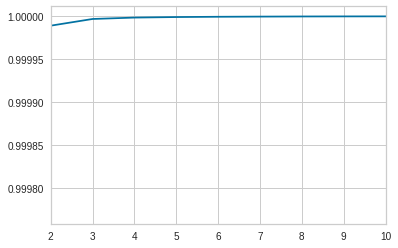

In [ ]:
#dim reduc PCA:
import numpy as np
from sklearn.decomposition import PCA
# Your code goes here
pcatf = PCA()
pcatf.fit(xtf_train)

pc_vs_variance_tf = np.cumsum(pcatf.explained_variance_ratio_)

pc_vs_variance_tf
plt.plot(pc_vs_variance_tf)
plt.xlim([2, 10])
# so let's use 6 components

After running PCA, we see that there is an 'elbow' at around 3, and assume that 6 components would be enough to explain almost all of the variance. Thus, we use 6 components. 

Now, we create a simple Logistic Regression model with a pipeline, fit it to the training data, and make predictions. 

In [ ]:
#linear regression using sklearn:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
scl = StandardScaler()
pca = PCA(n_components=6)

regr = LogisticRegression(max_iter=4000)
pipe = Pipeline(steps=[("scale",scl),("PCA",pca),("LogReg",regr)])
pipe.fit(xtf_train, ytf_train)


Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('PCA',
                 PCA(copy=True, iterated_power='auto', n_components=6,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('LogReg',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=4000,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

As done before, we use sklearn metrics to examine the logistic regression score and log_loss values for the predictions above. We find that the log_loss value is 0.304 and that the accuracy is around 0.932. 

In [ ]:
# check MSE on predictions above to see how model performs:
from sklearn.metrics import log_loss, accuracy_score

ytf_pred = pipe.predict(xtf_test)
probtf_pred = pipe.predict_proba(xtf_test)
ll = log_loss(ytf_test, probtf_pred)
scoretf = accuracy_score(ytf_pred, ytf_test)
print(ll, scoretf)


0.3096063954327448 0.9300870845087698


## Predicting Severity Using Simple Logistic

---

Regression with Spark

As done before, we want to make predictions using the split data defined above, to see if the T/F values can be used to predict severity. We use the csv made earlier to create a spark dataframe. Below we see the rows loaded and printed. 

In [ ]:
traintf_sdf = spark.read.csv("tf.csv", inferSchema=True, header=True)
traintf_sdf.show()

+-------+--------+------------------+-------------------+--------------------+-------+--------------+-----------+------------+--------------+---------------+-------------+------------+----------+---------+--------------+-------------+--------------+-------------+--------------+-------------+-------------+------------+-------------+------------+----------------+---------------+-------------+------------+----------+---------+---------------------+--------------------+--------------------+-------------------+------------------+------------------+--------------------+------------------+--------------------+---------------------+-----------------------+-------------------------+---------------------------+
|    _c0|Severity|         Start_Lat|          Start_Lng|        Distance(mi)|Zipcode|Temperature(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Speed(mph)|Amenity_False|Amenity_True|Bump_False|Bump_True|Crossing_False|Crossing_True|Give_Way_False|Give_Way_True|Junction_False|Junction_Tr

Now, we define an assembler and drop the _c0 column, which we can then use in  a pipeline to train our training set. 

In [ ]:
from pyspark.ml.feature import StringIndexer, VectorAssembler

drop_cols = ['_c0']
columns_to_use_tf = [i for i in traintf_sdf.columns if i not in drop_cols]

assembler_tf = VectorAssembler(inputCols=columns_to_use_tf, outputCol='features')

This is how we create the pipeline, like we did earlier, and we fit and transform this data. 

In [ ]:
from pyspark.ml import Pipeline
# Your code goes here
pipe_tf = Pipeline(stages=[assembler_tf])
modified_data_sdf_tf = pipe_tf.fit(traintf_sdf).transform(traintf_sdf)

Now, we split the data into 20% testing data and 80% training data. 

In [ ]:
traintf_sdf, testtf_sdf = modified_data_sdf_tf.randomSplit([0.8, 0.2])
traintf_sdf.show()

+-------+--------+------------------+-------------------+-------------------+-------+--------------+-----------+------------+--------------+---------------+-------------+------------+----------+---------+--------------+-------------+--------------+-------------+--------------+-------------+-------------+------------+-------------+------------+----------------+---------------+-------------+------------+----------+---------+---------------------+--------------------+--------------------+-------------------+------------------+------------------+--------------------+------------------+--------------------+---------------------+-----------------------+-------------------------+---------------------------+--------------------+
|    _c0|Severity|         Start_Lat|          Start_Lng|       Distance(mi)|Zipcode|Temperature(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Speed(mph)|Amenity_False|Amenity_True|Bump_False|Bump_True|Crossing_False|Crossing_True|Give_Way_False|Give_Way_True|Junctio

Now, like earlier, we do a PySpark Logistic Regression by fitting this to the training spark dataframe, and then we print a summary of the model to see if there is overfitting or underfitting. 

In [ ]:
# now do linear regression 
from pyspark.ml.classification import LogisticRegression

features_tf = modified_data_sdf_tf
lr_tf = LogisticRegression(featuresCol='features', labelCol='Severity')
lr_model_tf = lr_tf.fit(traintf_sdf)

In [ ]:
# view summary 
trainingSummary_tf = lr_model_tf.summary
print("FPR: %f" % trainingSummary_tf.weightedFalsePositiveRate)
print("TPR: %f" % trainingSummary_tf.weightedTruePositiveRate)
print("Precision: %f" % trainingSummary_tf.weightedPrecision)
print("Recall: %f" % trainingSummary_tf.weightedRecall)
print("Accuracy: %f" % trainingSummary_tf.accuracy)

FPR: 0.001650
TPR: 0.999834
Precision: 0.999834
Recall: 0.999834
Accuracy: 0.999834


Using the same method as before, we check for overfitting. Following methods from homework, we evaluate this model by predicting the model on our test set, making a regression evaluator. Similar to the scores above, we find small FPR and high Recall and Precision. 

In [ ]:
#check for overfitting:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

predictions_tf = lr_model_tf.transform(testtf_sdf)
eval_tf = MulticlassClassificationEvaluator(labelCol="Severity", predictionCol="prediction", metricName="accuracy")
acc_tf = eval_tf.evaluate(predictions_tf)
print(acc_tf)
eval2_tf = MulticlassClassificationEvaluator(labelCol="Severity", predictionCol="prediction", metricName="weightedFalsePositiveRate")
FPR_tf = eval2_tf.evaluate(predictions_tf)
print(FPR_tf)
eval3_tf = MulticlassClassificationEvaluator(labelCol="Severity", predictionCol="prediction", metricName="weightedRecall")
rec_tf = eval3_tf.evaluate(predictions_tf)
print(rec_tf)

0.9998527751877117
0.0013205243028473232
0.9998527751877118


We find that there is overfitting, and we can use regularizatio to improve this. Let's use Elastic Net regularization to improve this overfitting. 

In [ ]:
# regularize to avoid overfittinga, trying lasso, ridge, and elastic net to see which is best:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

features = modified_data_sdf_tf
en = LogisticRegression(featuresCol='features', labelCol='Severity', maxIter=10, regParam=.3, elasticNetParam=.8)
en_model = en.fit(traintf_sdf)
prediction_tf_2 = en_model.transform(testtf_sdf)
eval = MulticlassClassificationEvaluator(labelCol="Severity", predictionCol="prediction", metricName="accuracy")
acc_tf = eval.evaluate(predictions_tf)
print("Elastic Net:")
print(acc_tf)
eval2 = MulticlassClassificationEvaluator(labelCol="Severity", predictionCol="prediction", metricName="weightedFalsePositiveRate")
FPR_tf = eval2.evaluate(predictions_tf)
print(FPR_tf)
eval3 = MulticlassClassificationEvaluator(labelCol="Severity", predictionCol="prediction", metricName="weightedRecall")
rec_tf = eval3.evaluate(predictions_tf)
print(rec_tf)

Elastic Net:
0.9998527751877117
0.0013205243028473232
0.9998527751877118


We see from the evaluation that the accuracy and FPR are still large, which means that it is accurate at predicting this dataset.

# ***Beginning of Time Analysis:***
In this section, we are going to investigate possible relationships between time and number of accidents, looking for correlation and any interesting patterns in the data



## Exploratory Data Analysis

### Cleaning and preparing the data
Here we want to select a subset of the rows of our data, as we have way too many varied across sources and location, and we want a smaller set to work with, similar to the previous sections.

We choose to work only with data sourced from Bing, as that is one of two sources and all Bing rows have the same features. We will use the same data from the *Accident Weather Analysis* section:

We choose only the data from California and Washington, as that still gives us enough data to work with and analyze overall trends (this does make it so our finds are only representative of those two states, but trends in weather and time for example should be similar across similar states).
We also need to turn time into datatime objects for convenience later.

In [ ]:
my_df = b.copy()
my_df['month'] = my_df['Start_Time'].apply(lambda x : x.month)
my_df['year'] = my_df['Start_Time'].apply(lambda x : x.year)
my_df['day_num'] = my_df['Start_Time'].apply(lambda x : x.weekday())
my_df.head()

ID  Severity          Start_Time  ... month  year  day_num
0  A-2717612         3 2016-03-22 18:53:11  ...     3  2016        1
1  A-2717613         2 2016-03-22 19:00:49  ...     3  2016        1
2  A-2717614         3 2016-03-22 20:07:32  ...     3  2016        1
3  A-2717615         2 2016-03-22 21:40:18  ...     3  2016        1
4  A-2717616         2 2016-03-22 21:36:42  ...     3  2016        1

[5 rows x 50 columns]

### Analyzing Number of Accidents vs. Month of Year
We will be examining accidents between the years 2016-2020, analyzing the number of accidents for a given month within this time range. From the bar graph below,  we see that December was the month with the most number of accidents.

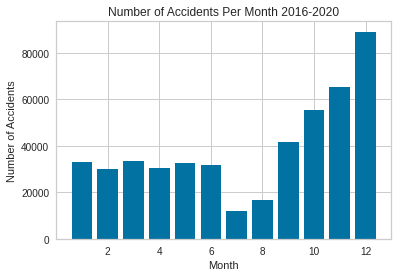

In [ ]:
# Number of Accidents Per Month

num_accidents_per_month = my_df.groupby('month').count()
num_accidents_per_month = num_accidents_per_month.reset_index()

plt.bar(num_accidents_per_month['month'], num_accidents_per_month['Start_Time'])
plt.title('Number of Accidents Per Month 2016-2020')
x_label = 'Month'
y_label = 'Number of Accidents'
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.show()

### Number of Accidents vs. Year
We can see a line graph displaying the number of accidents for a given year within 2016-2020. The year 2020 had the most number of accidents.

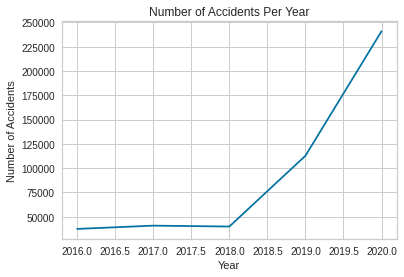

In [ ]:
# Number of Accidents Per Year

num_accidents_per_year = my_df.groupby('year').count()
num_accidents_per_year = num_accidents_per_year.reset_index()
num_accidents_per_year.head()
plt.plot(num_accidents_per_year['year'], num_accidents_per_year['Start_Time'])
plt.title('Number of Accidents Per Year')
plt.xlabel('Year')
plt.ylabel('Number of Accidents')
plt.show()

### Average Severity of Accidents vs. Month of Year
In addition to number of accidents, we will also analyze the average severity of these accidents. While the most number of accidents appeared to occur in December, July was the month with the highest average severity of accidents.

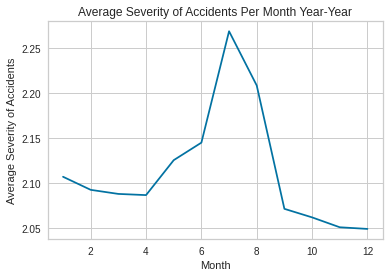

In [ ]:
# Average Severity of Accidents Per Month

avg_severity_per_month = my_df.groupby('month').mean()
avg_severity_per_month = avg_severity_per_month.reset_index()
avg_severity_per_month.head()
plt.plot(avg_severity_per_month['month'], avg_severity_per_month['Severity'])
plt.title('Average Severity of Accidents Per Month Year-Year')
x_label = 'Month'
y_label = 'Average Severity of Accidents'
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.show()

### Average Severity of Accidents vs. Year
We can see a line graph between the years 2016-2020 and average severity of accidents. The year 2018 had the highest average severity of accidents.

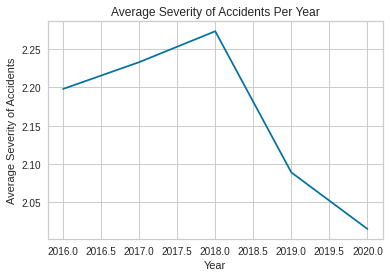

In [ ]:
# Average Severity of Accidents Per Year

avg_severity_per_year = my_df.groupby('year').mean()
avg_severity_per_year = avg_severity_per_year.reset_index()
avg_severity_per_year.head()
plt.plot(avg_severity_per_year['year'], avg_severity_per_year['Severity'])
plt.title('Average Severity of Accidents Per Year')
plt.xlabel('Year')
plt.ylabel('Average Severity of Accidents')
plt.show()

### Number of Accidents vs. Time of Day
We define the "times of day" as follows: \\
**Early Morning**: 5am - 12pm \\
**Afternoon**: 12pm - 5pm \\
**Evening**: 5pm - 9pm \\
**Night**: 9pm - 5am \\

The most number of accidents occur in the afternoon, according to the line graph below of number of accidents vs. time of day.

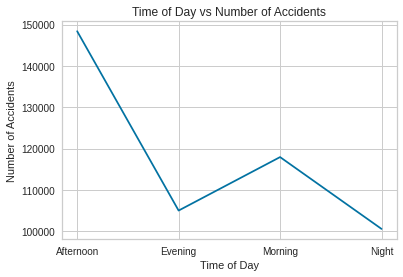

In [ ]:
def hour_to_part_day(hour):
  if hour >= 5 and hour < 12:
    return 'Morning'
  elif hour >= 12 and hour < 17:
    return 'Afternoon'
  elif hour >= 17 and hour < 21:
    return 'Evening'
  else:
    return 'Night'

my_df['time_of_day'] = my_df['Start_Time'].apply(lambda x : hour_to_part_day(x.hour))
part_of_day_df = my_df.groupby('time_of_day').count()
part_of_day_df = part_of_day_df.reset_index()
part_of_day_df.head()

plt.plot(part_of_day_df['time_of_day'], part_of_day_df['Start_Time'])
plt.title('Time of Day vs Number of Accidents')
plt.xlabel('Time of Day')
plt.ylabel('Number of Accidents')
plt.show()

### Number of Accidents vs. Day of the Week
The bar graph below shows the number of accidents that occur each day of the week during 2016-2020. The highest number of accidents appears to be on Thursday.

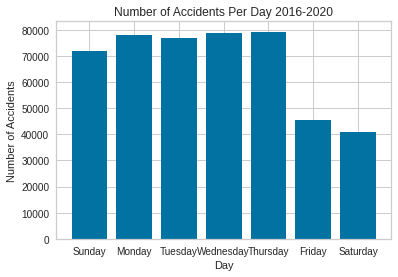

In [ ]:
# Number of Accidents Per Day
def day_num_to_word(num):
  if num == 0:
    return 'Sunday'
  elif num == 1:
    return 'Monday'
  elif num == 2:
    return 'Tuesday'
  elif num == 3:
    return 'Wednesday'
  elif num == 4:
    return 'Thursday'
  elif num == 5:
    return 'Friday'
  else:
    return 'Saturday'

num_accidents_per_day = my_df.groupby('day_num').count()
num_accidents_per_day = num_accidents_per_day.reset_index()
num_accidents_per_day['day_word'] = num_accidents_per_day['day_num'].apply(day_num_to_word)

plt.bar(num_accidents_per_day['day_word'], num_accidents_per_day['Start_Time'])
plt.title('Number of Accidents Per Day 2016-2020')
x_label = 'Day'
y_label = 'Number of Accidents'
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.show()

### Removing Seasonality
Since we are using time data, we want to remove seasonality from the data. We will use differencing using exponentially weighted moving averages (EWMA). We will still be comparing time and number of accidents, rounded up to the nearest integer.

In [ ]:
from statsmodels.tsa.stattools import adfuller
from pandas import Series

def test_stationarity(timeseries, lags=None):
  rolmean = Series.rolling(timeseries, center=False, window=12).mean()
  rolstd = Series.rolling(timeseries, center=False, window=12).std()

  orig = plt.plot(timeseries, color='blue', label='Original')
  mean = plt.plot(rolmean, color='red', label='Rolling Mean')
  std = plt.plot(rolstd, color='black', label='Rolling Std')
  plt.legend(loc='best')
  plt.title('Rolling Mean & Standard Deviation')
  plt.show(block=False)

  print('Results of ADF Test:')
  if lags:
    dftest = adfuller(timeseries, autolag=None, maxlag=lags)
  else:
    dftest = adfuller(timeseries, autolag='AIC')

  dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags', 'Observations'])
                     
  for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
  print(dfoutput)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from pandas import Series, DataFrame
import math

my_df['year_month'] = my_df['Start_Time'].apply(lambda x : str(x.year) + str(x.month))

my_new_df = my_df[['Severity', 'Start_Time', 'month', 'year', 'day_num', 'time_of_day', 'year_month', 'Visibility(mi)']]
my_new_df_by_month = my_new_df.groupby('year_month').count()
my_new_df_by_month = my_new_df_by_month.reset_index()
my_new_df_by_month.head()

moving_avg = Series.rolling(my_new_df['Severity'], center=False, window=12).mean()
my_new_df['accidents_diff'] = my_new_df['Severity'] - moving_avg
df_moving_avg = my_new_df[['month', 'year', 'day_num', 'accidents_diff']].dropna(inplace = False)
df_moving_avg['accidents_diff_rnd'] = df_moving_avg['accidents_diff'].apply(lambda x : abs(math.ceil(x)))
df_moving_avg = df_moving_avg[['month', 'year', 'day_num', 'accidents_diff_rnd']].dropna(inplace = False)
df_moving_avg.head()

month  year  day_num  accidents_diff_rnd
11      3  2016        2                   0
12      3  2016        2                   0
13      3  2016        2                   0
14      3  2016        2                   0
15      3  2016        2                   0

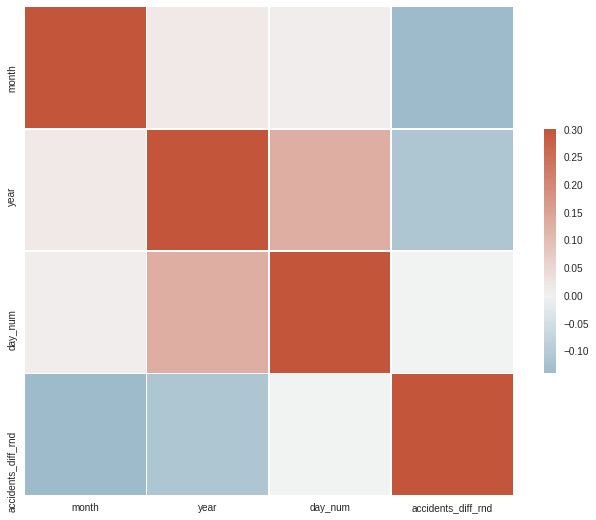

In [ ]:
# source for correlation matrix: https://seaborn.pydata.org/examples/many_pairwise_correlations.html
corr = df_moving_avg.corr()
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


We can see from the above correlation matrix that the time data is not extremely correlated with each other, however, we will still analyze the time features and be aware of the correlation between the day of the week and year.

## Setup data and use for simple sklearn regression analysis

Here we want to perform sklearn regression analysis as we learned in lecutre and HW, one of the most basic regression methods to see how well we can predict number of accidents (category) using the rest of the features. Note: we need to use logistic regression as opposed to linear as we have a classification problem here. 

Here we identify labels and features, split into train and test sets, and save the time dataset to a csv for future use.

In [ ]:
#Split to x and y

label = df_moving_avg["accidents_diff_rnd"]
features = df_moving_avg.loc[:, df_moving_avg.columns != 'accidents_diff_rnd']
df_moving_avg.to_csv('time.csv')

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(features, label, test_size=0.2)

What we're doing here is we want to check the number of components (using PCA) to see how many explain almost all of the variance. We do this to reduce dimensionality to reduce complexity, reduce risk of overfitting, and maximize variance. We find that 2 components explain almost all of the variance so we choose to use 2 components later in this section.

(0.0, 15.0)

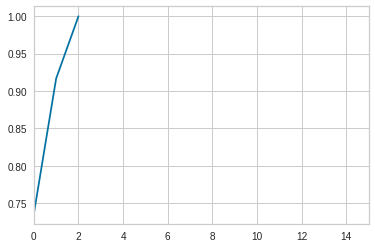

In [ ]:
#PCA:
import numpy as np
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(x_train)

pc_vs_variance = np.cumsum(pca.explained_variance_ratio_)

pc_vs_variance
plt.plot(pc_vs_variance)
plt.xlim([0, 15])

To avoid multicollinearity, we create a simple Logistic Regression model with a pipeline, fit it with the train data, and make predictions using the x test set. Note that the default logistic regression penalty is L2, so we should check Elastic Net and L1 later to see if they're any better!

In [ ]:
#linear regression using sklearn:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.pipeline import Pipeline
scl = StandardScaler()
pca = PCA(n_components=2)
regr = LogisticRegression(max_iter=4000)
pipe = Pipeline(steps=[("scale",scl),("PCA",pca),("LogReg",regr)])
pipe.fit(x_train, y_train)

Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('PCA',
                 PCA(copy=True, iterated_power='auto', n_components=2,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('LogReg',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=4000,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

Now we use sklearn metrics to examine the logistic regression score and log_loss (cross-entropy really) values for the predictions made above. We find that they are both pretty good actually, with log loss being somewhat small and accuracy actually very high, so we already have a model that predicts accident severity based on features decently well.

Note: we *must* use cross-entropy loss for classification and logistic regression as well, linear regression and RMSE or R2 would be very bad and not actually give us the results we are looking for when our goal is multi-class classification.

In [ ]:
# check MSE on predictions above to see how model performs:
from sklearn.metrics import log_loss, accuracy_score

y_pred = pipe.predict(x_test)
prob_pred = pipe.predict_proba(x_test)
prob_pred.shape
ll = log_loss(y_test, prob_pred, labels = label)
score = accuracy_score(y_pred, y_test)
print(ll, score)


0.37374734865949655 0.8955015100937848


## Predicting Severity Using Simple Logistic Regression with Spark, Tuned for Comparing Models (L1, L2, Elastic Net, and Random Forest)

In this section we use a variety of semi-simple Spark models (logistic regression mostly) to make predictions using our data split into train and test sets in a similar way as above. Number of accidents is the category we are predicting, and the rest of the time-related attributes are all of the features we have available. We see that we get very good Cross-Entropy Loss, accuracy, and other measures by the very end, and we also make conclusions about different models and parameters based on their outputs below.

### Perform the Logistic Regression

In [ ]:
train_sdf = spark.read.csv("time.csv", inferSchema=True, header=True)
train_sdf.show()

+---+-----+----+-------+------------------+
|_c0|month|year|day_num|accidents_diff_rnd|
+---+-----+----+-------+------------------+
| 11|    3|2016|      2|                 0|
| 12|    3|2016|      2|                 0|
| 13|    3|2016|      2|                 0|
| 14|    3|2016|      2|                 0|
| 15|    3|2016|      2|                 0|
| 16|    3|2016|      2|                 0|
| 17|    3|2016|      2|                 0|
| 18|    3|2016|      2|                 0|
| 19|    3|2016|      2|                 1|
| 20|    3|2016|      2|                 0|
| 21|    3|2016|      2|                 0|
| 22|    3|2016|      2|                 0|
| 23|    3|2016|      2|                 0|
| 24|    3|2016|      2|                 1|
| 25|    3|2016|      2|                 0|
| 26|    3|2016|      2|                 1|
| 27|    3|2016|      2|                 0|
| 28|    3|2016|      2|                 0|
| 29|    3|2016|      2|                 0|
| 30|    3|2016|      2|        

Here we get rid of the index column and then create a vector assembler so that we can use a pyspark pipeline to transform our data. This makes it so we can easily define our label (number of accidents) and features and then split into train and test sets.

In [ ]:
from pyspark.ml.feature import StringIndexer, VectorAssembler

drop_cols = ['_c0']
columns_to_use = [i for i in train_sdf.columns if i not in drop_cols]

assembler = VectorAssembler(inputCols=columns_to_use, outputCol='features')

Create the pipeline here, where out only stage is the vector assembler from above. Fit and transform the train_sdf so it is ready to use below in splitting and then the following models.

In [ ]:
from pyspark.ml import Pipeline

pipe = Pipeline(stages=[assembler])
modified_data_sdf = pipe.fit(train_sdf).transform(train_sdf)

Split the data for training and testing - training data allows us to train the model as we use 80% of the data there, and then we use the 20% to test our training of the model and we evaluate our predictions.

In [ ]:
train_sdf, test_sdf = modified_data_sdf.randomSplit([0.8, 0.2])
train_sdf.show()

+---+-----+----+-------+------------------+--------------------+
|_c0|month|year|day_num|accidents_diff_rnd|            features|
+---+-----+----+-------+------------------+--------------------+
| 11|    3|2016|      2|                 0|[3.0,2016.0,2.0,0.0]|
| 12|    3|2016|      2|                 0|[3.0,2016.0,2.0,0.0]|
| 13|    3|2016|      2|                 0|[3.0,2016.0,2.0,0.0]|
| 15|    3|2016|      2|                 0|[3.0,2016.0,2.0,0.0]|
| 16|    3|2016|      2|                 0|[3.0,2016.0,2.0,0.0]|
| 17|    3|2016|      2|                 0|[3.0,2016.0,2.0,0.0]|
| 18|    3|2016|      2|                 0|[3.0,2016.0,2.0,0.0]|
| 20|    3|2016|      2|                 0|[3.0,2016.0,2.0,0.0]|
| 21|    3|2016|      2|                 0|[3.0,2016.0,2.0,0.0]|
| 22|    3|2016|      2|                 0|[3.0,2016.0,2.0,0.0]|
| 23|    3|2016|      2|                 0|[3.0,2016.0,2.0,0.0]|
| 24|    3|2016|      2|                 1|[3.0,2016.0,2.0,1.0]|
| 26|    3|2016|      2| 

Now what we want to do is start with a PySpark Logistic Regression (again needed because we have multi-class classification) so that we can compare it to the above logistic regression in sklearn and later more complex models. First we note which columns are features and which is the label (any that are not Severity and Severity respectively), and then we fit the LR model with the train spark dataframe.

After fitting the model, we get the summary of the model and see that it has FPR = 0.0 and accuracy, FPR, recall, and precision = 1.0 which are all (too) perfect. This means we should check for overfitting to make sure the model is not too closely fit to our train data.

In [ ]:
# now do logistic regression 
from pyspark.ml.classification import LogisticRegression

features = modified_data_sdf
lr = LogisticRegression(featuresCol='features', labelCol='accidents_diff_rnd')
lr_model = lr.fit(train_sdf)

In [ ]:
# view summary 
trainingSummary = lr_model.summary
print("FPR: %f" % trainingSummary.weightedFalsePositiveRate)
print("TPR: %f" % trainingSummary.weightedTruePositiveRate)
print("Precision: %f" % trainingSummary.weightedPrecision)
print("Recall: %f" % trainingSummary.weightedRecall)
print("Accuracy: %f" % trainingSummary.accuracy)

FPR: 0.000000
TPR: 1.000000
Precision: 1.000000
Recall: 1.000000
Accuracy: 1.000000


Check for overfitting: First we need to evaluate our model by making predictions using our model on our test set, make a regression evaluator with the prediction and label columns as defined by the model, and make sure to check the accuracy and possibly one or two other metrics of the model (many possible metrics like FPR, TPR, and recall, choose a couple). We use evaluate and find that the accuracy is VERY high, and perhaps it is too high and we can get good results with our model with a bit less complexity (i.e. we may have overfitting and not need such a tightly fit model). We see the same with a tiny FPR and high recall/precision.

In [ ]:
#check for overfitting:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

predictions = lr_model.transform(test_sdf)
eval = MulticlassClassificationEvaluator(labelCol="accidents_diff_rnd", predictionCol="prediction", metricName="accuracy")
acc = eval.evaluate(predictions)
print(acc)
eval2 = MulticlassClassificationEvaluator(labelCol="accidents_diff_rnd", predictionCol="prediction", metricName="weightedFalsePositiveRate")
FPR = eval2.evaluate(predictions)
print(FPR)
eval3 = MulticlassClassificationEvaluator(labelCol="accidents_diff_rnd", predictionCol="prediction", metricName="weightedRecall")
rec = eval3.evaluate(predictions)
print(rec)

1.0
0.0
1.0


Here we should use Lasso, Ridge, and Elastic Net regularization to improve the overfitting and complexity of our model. We use L1 by setting the Elastic Net parameter to 1, L2 by setting it to 0, and a combination of both (Elastic Net) by setting it to a value of 0.8. 

We then make a new LR model for each case and fit the train data, make predictions using the test set, and make another evaluator object in the same way as above to check the accuracy of each modified model. 

In [ ]:
# regularize to avoid overfittinga, trying lasso, ridge, and elastic net to see which is best:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

features = modified_data_sdf
l1 = LogisticRegression(featuresCol='features', labelCol='accidents_diff_rnd', maxIter=10, regParam=.3, elasticNetParam=1)
l1_model = l1.fit(train_sdf)
prediction = l1_model.transform(test_sdf)
eval = MulticlassClassificationEvaluator(labelCol="accidents_diff_rnd", predictionCol="prediction", metricName="accuracy")
acc = eval.evaluate(predictions)
print("L1:")
print(acc)
eval2 = MulticlassClassificationEvaluator(labelCol="accidents_diff_rnd", predictionCol="prediction", metricName="weightedFalsePositiveRate")
FPR = eval2.evaluate(predictions)
print(FPR)
eval3 = MulticlassClassificationEvaluator(labelCol="accidents_diff_rnd", predictionCol="prediction", metricName="weightedRecall")
rec = eval3.evaluate(predictions)
print(rec)

features = modified_data_sdf
l2 = LogisticRegression(featuresCol='features', labelCol='accidents_diff_rnd', maxIter=10, regParam=.3, elasticNetParam=0)
l2_model = l2.fit(train_sdf)
prediction = l2_model.transform(test_sdf)
eval = MulticlassClassificationEvaluator(labelCol="accidents_diff_rnd", predictionCol="prediction", metricName="accuracy")
acc = eval.evaluate(predictions)
print("L2:")
print(acc)
eval2 = MulticlassClassificationEvaluator(labelCol="accidents_diff_rnd", predictionCol="prediction", metricName="weightedFalsePositiveRate")
FPR = eval2.evaluate(predictions)
print(FPR)
eval3 = MulticlassClassificationEvaluator(labelCol="accidents_diff_rnd", predictionCol="prediction", metricName="weightedRecall")
rec = eval3.evaluate(predictions)
print(rec)

features = modified_data_sdf
en = LogisticRegression(featuresCol='features', labelCol='accidents_diff_rnd', maxIter=10, regParam=.3, elasticNetParam=.8)
en_model = en.fit(train_sdf)
prediction = en_model.transform(test_sdf)
eval = MulticlassClassificationEvaluator(labelCol="accidents_diff_rnd", predictionCol="prediction", metricName="accuracy")
acc = eval.evaluate(predictions)
print("Elastic Net:")
print(acc)
eval2 = MulticlassClassificationEvaluator(labelCol="accidents_diff_rnd", predictionCol="prediction", metricName="weightedFalsePositiveRate")
FPR = eval2.evaluate(predictions)
print(FPR)
eval3 = MulticlassClassificationEvaluator(labelCol="accidents_diff_rnd", predictionCol="prediction", metricName="weightedRecall")
rec = eval3.evaluate(predictions)
print(rec)



L1:
1.0
0.0
1.0
L2:
1.0
0.0
1.0
Elastic Net:
1.0
0.0
1.0


So we see from above that the each still does too well in predicting the classification desired. There are two reasons this could be: First, it could be that the model is still overfitting, even though we tested multiple versions of the model with different regularization, iterations, and the regparam as we have hypertuned in the past. It could also be that the data (and our classes) are easily predicted by the features we have on hand. We will now move on to different models to test their capabilities compared to these, but a possible future direction would be exploring the above logistic regression with less features or more regularization to see if it really is easy to predict or if we are currently overfitting.

Now another kind of regularization and regression we will do is the Random Forest from PySpark. Do this to hopefully reduce overfitting as well, and follow much of the same process as above. Create the model, fit the train sdf, make predictions on the train and test set. When we evaluate using accuracy, recall, and precision again, we see that again all are = 1.0, which is technically good! This means the random forest is also very good at predicting our classes, though it is possible that it still has the problem of overfitting as discussed above.

In [ ]:
# do random forest regression to see if it's any better:
from pyspark.ml.regression import RandomForestRegressor
features = modified_data_sdf
rf = RandomForestRegressor(featuresCol="features", labelCol='accidents_diff_rnd')
rf_model = rf.fit(train_sdf)

In [ ]:
# make predictions and evaluate:
predictionTr = rf_model.transform(train_sdf)
predictionTe = rf_model.transform(test_sdf)

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
eval = MulticlassClassificationEvaluator(labelCol="accidents_diff_rnd", predictionCol="prediction", metricName="accuracy")
acc = eval.evaluate(predictions)
print(acc)
eval2 = MulticlassClassificationEvaluator(labelCol="accidents_diff_rnd", predictionCol="prediction", metricName="weightedPrecision")
prec = eval2.evaluate(predictions)
print(prec)
eval3 = MulticlassClassificationEvaluator(labelCol="accidents_diff_rnd", predictionCol="prediction", metricName="weightedRecall")
rec = eval3.evaluate(predictions)
print(rec)


1.0
1.0
1.0


### PCA and LR to Compare to Above

For our final regression model in the PySpark section, we will use PCA to reduce dimensionality and complexity and evaluate a new linear regression model and check the results against the above models.

We first use the PCA number of components (k=2) found above, select the correct input and output columns, and fit the PCA model on the train set. Then we transform the test and train sets using the PCA model and select their features. Finally we use an elastic net logistic regression and fit the train sdf, and then make predictions on the train and test sets.

We use evaluators as above and check the accuracy, and we find that find that the values are very very close to 1. This is very small so could be due to overfitting, but both train and test accuracy are high are very small so it could be that our model just predicts the features very well.

In [ ]:
# PCA for dimensionality reduction:
from pyspark.ml.feature import PCA
# num features from way before
pca = PCA(k=2, inputCol="features", outputCol='pcaFeatures')
pca_model = pca.fit(train_sdf)

train_sdf = pca_model.transform(train_sdf)
train_feat = train_sdf.select('accidents_diff_rnd', 'pcaFeatures')

test_sdf = pca_model.transform(test_sdf)
test_feat = test_sdf.select('accidents_diff_rnd', 'pcaFeatures')


lr_new = LogisticRegression(featuresCol='pcaFeatures', labelCol='accidents_diff_rnd', regParam=.3, elasticNetParam=.8)
lr_model_new = lr.fit(train_sdf)

pred1 = lr_model_new.transform(train_sdf)

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
eval = MulticlassClassificationEvaluator(labelCol="accidents_diff_rnd", predictionCol="prediction", metricName="accuracy")
acc = eval.evaluate(pred1)
print("Training Evaluation:")
print(acc)
eval2 = MulticlassClassificationEvaluator(labelCol="accidents_diff_rnd", predictionCol="prediction", metricName="weightedPrecision")
prec = eval2.evaluate(pred1)
print(prec)
eval3 = MulticlassClassificationEvaluator(labelCol="accidents_diff_rnd", predictionCol="prediction", metricName="weightedRecall")
rec = eval3.evaluate(pred1)
print(rec)

Training Evaluation:
1.0
1.0
1.0


In [ ]:
pred1.select("prediction", "accidents_diff_rnd", "features").show(5)

+----------+------------------+--------------------+
|prediction|accidents_diff_rnd|            features|
+----------+------------------+--------------------+
|       0.0|                 0|[3.0,2016.0,2.0,0.0]|
|       0.0|                 0|[3.0,2016.0,2.0,0.0]|
|       0.0|                 0|[3.0,2016.0,2.0,0.0]|
|       0.0|                 0|[3.0,2016.0,2.0,0.0]|
|       0.0|                 0|[3.0,2016.0,2.0,0.0]|
+----------+------------------+--------------------+
only showing top 5 rows



In [ ]:
# predictions from PCA one:
predictions = lr_model_new.transform(test_sdf)
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
eval = MulticlassClassificationEvaluator(labelCol="accidents_diff_rnd", predictionCol="prediction", metricName="accuracy")
acc = eval.evaluate(predictions)
print("Testing Evaluation:")
print(acc)
eval2 = MulticlassClassificationEvaluator(labelCol="accidents_diff_rnd", predictionCol="prediction", metricName="weightedPrecision")
prec = eval2.evaluate(predictions)
print(prec)
eval3 = MulticlassClassificationEvaluator(labelCol="accidents_diff_rnd", predictionCol="prediction", metricName="weightedRecall")
rec = eval3.evaluate(predictions)
print(rec)
# results: we have very high accuracy here which is good but may be overfittin


Testing Evaluation:
1.0
1.0
1.0


In [ ]:
predictions.select("prediction", "accidents_diff_rnd", "features").show(5)

+----------+------------------+--------------------+
|prediction|accidents_diff_rnd|            features|
+----------+------------------+--------------------+
|       0.0|                 0|[3.0,2016.0,2.0,0.0]|
|       1.0|                 1|[3.0,2016.0,2.0,1.0]|
|       0.0|                 0|[3.0,2016.0,2.0,0.0]|
|       0.0|                 0|[3.0,2016.0,2.0,0.0]|
|       0.0|                 0|[3.0,2016.0,2.0,0.0]|
+----------+------------------+--------------------+
only showing top 5 rows



## Section Conclusion:

In this section we did varying degrees of analysis on the time-focused attributes of our accident dataset. We began with some data cleaning that was necessary to select and transform some of the features we wanted to observe and make sure we had enough (but not too many) observations to work with. 

We then plotted the time data against number of accidents and severity of accidents to get a general idea of the trends in our data. We didn't see too many relationships between pairs of features, but we continued to examine time data against the number of accidents.

After visualizing our data and making conclusions, we moved into regression analysis through Sci-kit Learn and Spark. We used differencing with EWMA to get rid of the seasonality from the data. We used logistic regression analysis to train models to classify the number of accidents into three categories. 

We found that the logistic regression models did not perform too well. Even though they had high accuracy and low error, the model may be overfitted to the data. However, it is very accurate in predicting the number of accidents. To address the overfitting, we would probably need to try more in-depth hyperparameter tuning or possibly use other methods not learned in class. 

Overall, while we couldn't find much correlation between the time data and the number of accidents, it was interesting to analyze the trends in time and create different models to predict the number of accidents based on time-related features. 

********************************

# ***Project Conclusion***
In summary, the three major sections above proved very useful in examining the trends in our accident data, throughout our visualization, EDA, and modeling processes. 

In the weather section we saw that many weather features like visibility and temperature were strongly correlated with the severity of an accident, as was to be expected. We also found that different weather types featured sizeable variations in severity, and that some data was messy in the beginning but much more readable with some regularization. Lastly we tried many variations on the logistic regression model to predict severity using weather attributes and ended up doing well. A simple neural network also did very well predicting the severity of an accident using one-hot encoded weather features. 

In the location section it was very interesting to plot the density of accidents over a map of Washington State and California, as it basically outlined the major highways of both states (this conclusion makes sense and was a cool way to identify major roadways). PCA and logistic regression resulted in a model with small loss and high accuracy (using elastic net), which was the goal in predicting severity – we had similar results using location features as we did with weather features, which was good! 

We analyzed the time section of the data as well to look for number of accidents and average severity when compared with different times, months, and years. We found through visualization that accidents are more frequent in the winter months (probably because of weather), and the least common in the middle of the summer. The number of accidents has also been increasing since 2018 until 2020, though average severity has been dropping. An interesting finding was that average severity of accidents spiked during summer months, which could be because of number of people involved. Accidents were also most common in the afternoon and morning, which was somewhat surprising but could be explained by the setting and rising sun and visibility in those respective cases. Lastly we did a logistic regression that had similar results as the models discussed above – all had high accuracy, low loss, and did well predicting our data. 


In terms of future direction, we would probably want to analyze connections between the three above sections of analysis. How does time correlate with weather to affect accident severity? Does weather corrleate with location to create more or less severity in accidents? It would not be too hard to take a different subset of features to discover these results and would use similar models as the ones we have used here to do that analysis. We could also get into the other features of the dataset a little more closely (traffic elements) or compare the two different sources for the data to see if there are any nuances we missed. Finally we could expand our analysis to more states, the entire United States, or try to find data on more countries to examine similarities and differences across a wider data set.

Overall, we were able to apply a variety of topics from the homeworks and lectures to be able to visualize, explore, and make predictions on our accident data. The project allowed us to apply what we learned to create real results, and it was both challenging and exciting figuring out all of problems we encountered. Thank you for reading our project!